# **Izazov 365: Kako bicikle učiniti prvim izborom svaki dan?**
## **Otkrivanje znanja u podacima**
### **Informacijski i poslovni sustavi**
#### **Petar Perenčević & Maksim Kos**

---

#### **Uvoz biblioteka**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import RobustScaler

#### **Učitavanje podataka**

In [2]:
data = pd.read_csv('data/bikesharing_daily.csv')
data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


#### **Provjera podataka**

In [3]:
data.shape

(731, 16)

Skup podataka sadrži 731 red i 16 stupaca

In [4]:
data.columns.unique()

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

In [5]:
print(data.dtypes)

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object


Skup podataka sadrži:
- 11 atributa tipa `int64` - cijeli brojevi
- 4 atributa tipa `float64` - decimalni brojevi
- 1 atribut tipa `object` - tekstualni opis

Također je vidljivo kako svaki atribut ima 731 ne-null vrijednosti što ukazuje da su podaci **potpuni**

**Opis pojedinog atributa:**
- `instant` -> redni broj instance
- `dteday` -> datum (u formatu YYYY-MM-DD)
- `season` -> godišnja doba (proljeće, ljeto, jesen, zima)
- `yr` -> godina (0 = 2011, 1 = 2012)
- `mnth`-> mjeseci u godini (1-12)
- `holiday` -> praznici (1 = praznik, 0 = nije praznik)
- `weekday` -> dani u tjednu (0 = nedjelja, 1 = ponedjeljak, ..., 6 = subota)
- `workingday` -> radni dani (1 ako je dan radni, 0 inače)
- `weathersit`-> vremenska prognoza (sunčano, kišovito, ...)
- `temp` -> temperatura - atribut je normaliziran
- `atemp` -> osjećaj temperature - atribut je normaliziran
- `hum` -> vlažnost zraka - atribut je normaliziran
- `windspeed` -> brzina vjetra - atribut je normaliziran
- `casual` -> korisnici bez registracije (npr. turisti, rekreativci, ...)
- `registered` -> korisnici koji imaju registrirani račun (pretplatnici)
- `cnt` -> ukupan broj bicikala iznajmljenih tog dana

---

#### **Čišćenje podataka**

Dodatna provjera null vrijednosti atributa:

In [6]:
data.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

Provjera duplikata:

In [7]:
data.duplicated().sum()

0

In [8]:
provjera = data['casual'] + data['registered'] == data['cnt']
nepodudaranja = data[~provjera]
print(f"Broj redaka gdje zbroj nije jednak: {len(nepodudaranja)}")


Broj redaka gdje zbroj nije jednak: 0


#### **Uklanjanje nepotrebnih atributa:**

In [9]:
data.columns.unique()

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

**Atribut `dteday`**

Prvi atribut koji bi bilo dobro izbaciti je `dteday`, koji predstavlja datum. Budući da već imamo atribute `holiday` (za blagdane/praznike), `weekday` (dane u tjednu) i `workingday` (radne/neradne dane), `dteday` nam nije potreban jer ne donosi dodatne informacije za analizu.

In [10]:
data_final = data.copy()
data_final = data_final.drop(columns='dteday')

---

Atibut `dteday` nam je bio potreban jedino za prepoznavanje vrijednosti navedenih atributa:
- `holiday` - 1 = praznik / 0 = nije praznik
- `weekday` - 0 = nedjelja; 1 = ponedjeljak, 2 = utorak, ..., 6 = subota
- `workingday` - 1 = radni dan / 0 = neradni dan

---

In [11]:
data['holiday'].unique()

array([0, 1], dtype=int64)

**Atribut `instant`**

Također, još jedan atribut koji bi bilo dobro izbaciti je `instant`, jer on zapravo predstavlja *ID* instance, što nam nije potrebno za analizu i ne nosi nikakvu dodatnu informaciju koja bi bila korisna za donošenje zaključaka.

In [12]:
data_final = data_final.drop(columns='instant')

**Početna korelacijska matrica**

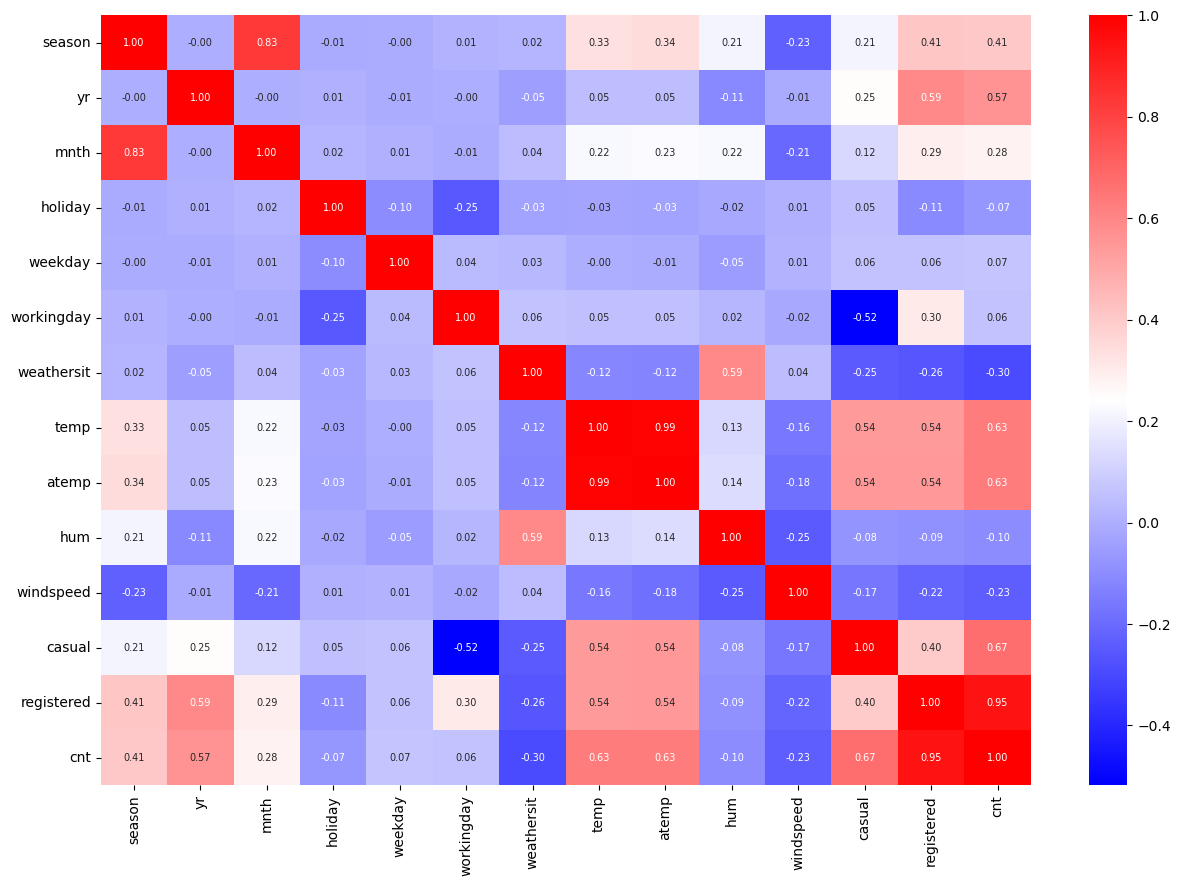

In [13]:
plt.figure(figsize=(15, 10))
sns.heatmap(data_final.corr(), annot=True, cmap="bwr", annot_kws={"size":7}, fmt='.2f')
plt.show()

**Atribut `season`**

In [14]:
data['season'].unique()

array([1, 2, 3, 4], dtype=int64)

In [15]:
print(data['mnth'].unique())

[ 1  2  3  4  5  6  7  8  9 10 11 12]


Atribut `season` ima samo 4 vrijednosti koje predstavljaju godišnja doba, dok atribut `mnth` ima 12 vrijednosti koje predstavljaju mjesece u godini. Budući da znamo koji mjesec pripada kojem godišnjem dobu, atribut `season` je redundantan i može se ukloniti
- `season` daje manje informacija
- `mnth` je precizniji za analizu vremena

In [16]:
data_final = data_final.drop(columns='season')

**Atribut `atemp`**

Na prethodnoj korelacijskoj matrici možemo vidjeti kako atributi `atemp` i `temp` imaju jako visoku povezanost, što može zbuniti model.
- Iz razloga što ljudi kod odlučivanja obično gledaju stvarnu temperaturu, a ne kako se ona "osjeća", atribut `atemp` možemo također ukloniti

In [17]:
data_final = data_final.drop(columns='atemp')

**Završna korelacijska matrica**

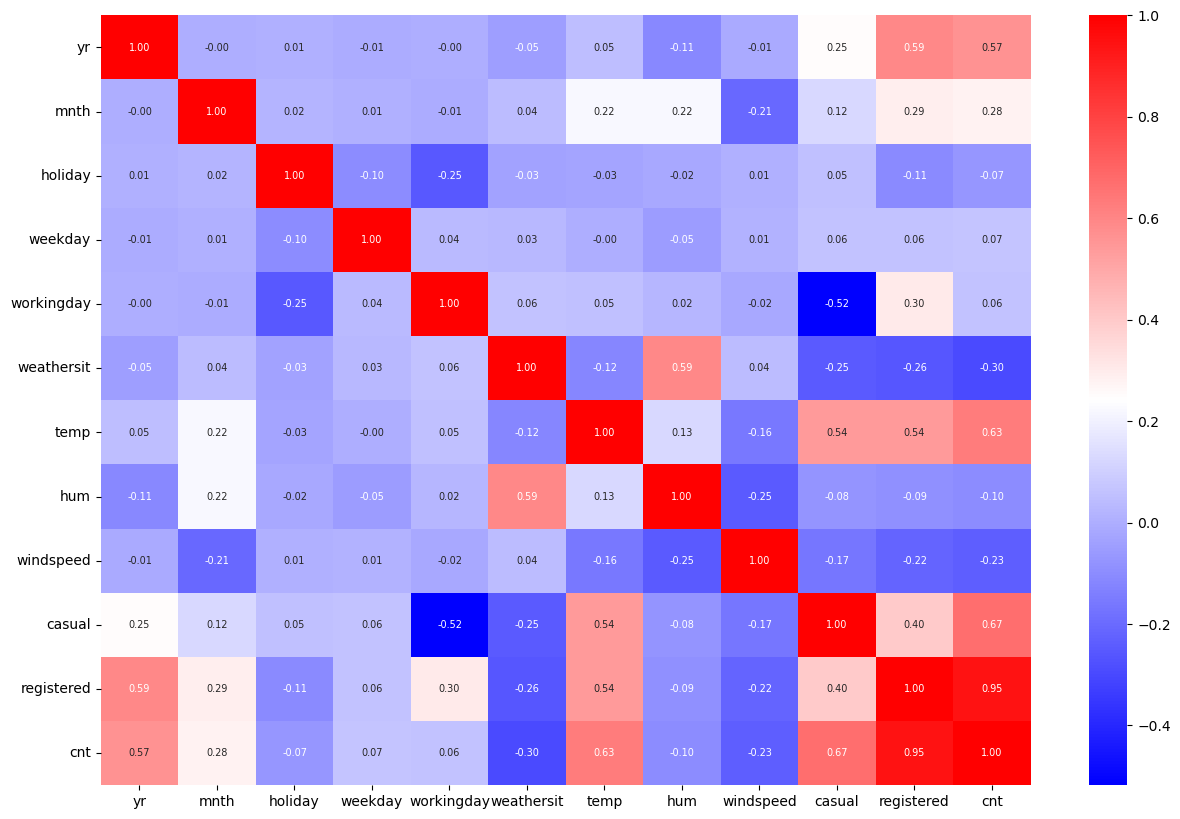

In [18]:
plt.figure(figsize=(15, 10))
sns.heatmap(data_final.corr(), annot=True, cmap="bwr", annot_kws={"size":7}, fmt='.2f')
plt.show()

Sa korelacijske matrice može se zaključiti sljedeće:
- Odnos atributa `yr` i `registered`
  - Kako je godina porasla, tako se i broj registriranih korisnika povećao.
    - > Npr. bolja promocija, pogodnosti registracije - veća svijest korisnika o prednostima koje ona donosi
- Odnos atributa `workingday`, `casual`, `registered`
  - Porastom vrijednosti atributa `workingday` (0->1(radni dan)), broj rekreativnih korisnika se smanjuje, dok se broj registriranih korisnika povećava
    - > Radnim danima, registrirani korisnici voze bicikle više, dok vikendima više voze rekreativci
      - > Zaposlenima se više isplati biti registriran zbog pogodnosti koje im registracija nudi (maybe)
- Odnos atributa `casual` i `temperature`
  - Korelacijska matrica ukazuje da povećanje temperature pozitivno povlači sa sobom i broj rekreativaca
    - > Rekreativci se više voze kada je vani lijepo vrijeme
    - Isto vrijedi i za registrirane korisnike
    - Također, kako brzina vjetra raste, tako se i ukupan broj korisnika smanjuje (blago negativna korelacija)
- Odnos atributa `weathersir` i `cnt`
  - Atributi imaju negativnu korelaciju, što znači da manje vrijednosti predstavljaju bolje vremenske uvjete
    - > Ovo bi se možda moglo srediti na način da se za vrijeme lošeg vremena ponudi bolji popust ili nešto ??
- Atributi `hum` i `cnt`
  - Vlaga nema skoro nikakvu korelaciju s brojem korisnikama
    - Atribut `hum` treba maknuti (možda) - Pero i ja ćemo se još dog. za to :)

---

#### **Deskriptivna statistika**

Za početak ćemo napraviti osnovni pregled numeričkih varijabli pomoću funkcije `describe()`, koja nam daje osnovne statističke mjere za svaki atribut:
- ukupan broj zapisa
- srednja vrijednost
- standardna devijacija
- najmanja vrijednost
- najveća vrijednost
- kvartili (Q1, Q2(medijan), Q3)

In [19]:
data_final[['temp', 'hum', 'windspeed', 'casual', 'registered', 'weathersit']].describe()

,temp,hum,windspeed,casual,registered,weathersit
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,0.495385,0.627894,0.190486,848.176471,3656.172367,1.395349
std,0.183051,0.142429,0.077498,686.622488,1560.256377,0.544894
min,0.059130,0.000000,0.022392,2.000000,20.000000,1.000000
25%,0.337083,0.520000,0.134950,315.500000,2497.000000,1.000000
50%,0.498333,0.626667,0.180975,713.000000,3662.000000,1.000000
75%,0.655417,0.730209,0.233214,1096.000000,4776.500000,2.000000
max,0.861667,0.972500,0.507463,3410.000000,6946.000000,3.000000


Najznačajnija informacija je ta da broj registriranih korisnika je u prosjeku mnogo veći od broja rekreativnih korisnika.
- To mogu biti studenti ili zaposlenici koji voze radnim danom (maybe?)
- Rekreativci su manji dio korisnika, ali su potencijal za rast - vikendaima uz dobre vremenske uvjete
  - Izmisliti način na koji će se potaknuti studenti i zaposlenici da voze više vikendima,
  - te da rekreativci vise voze tjednom

---

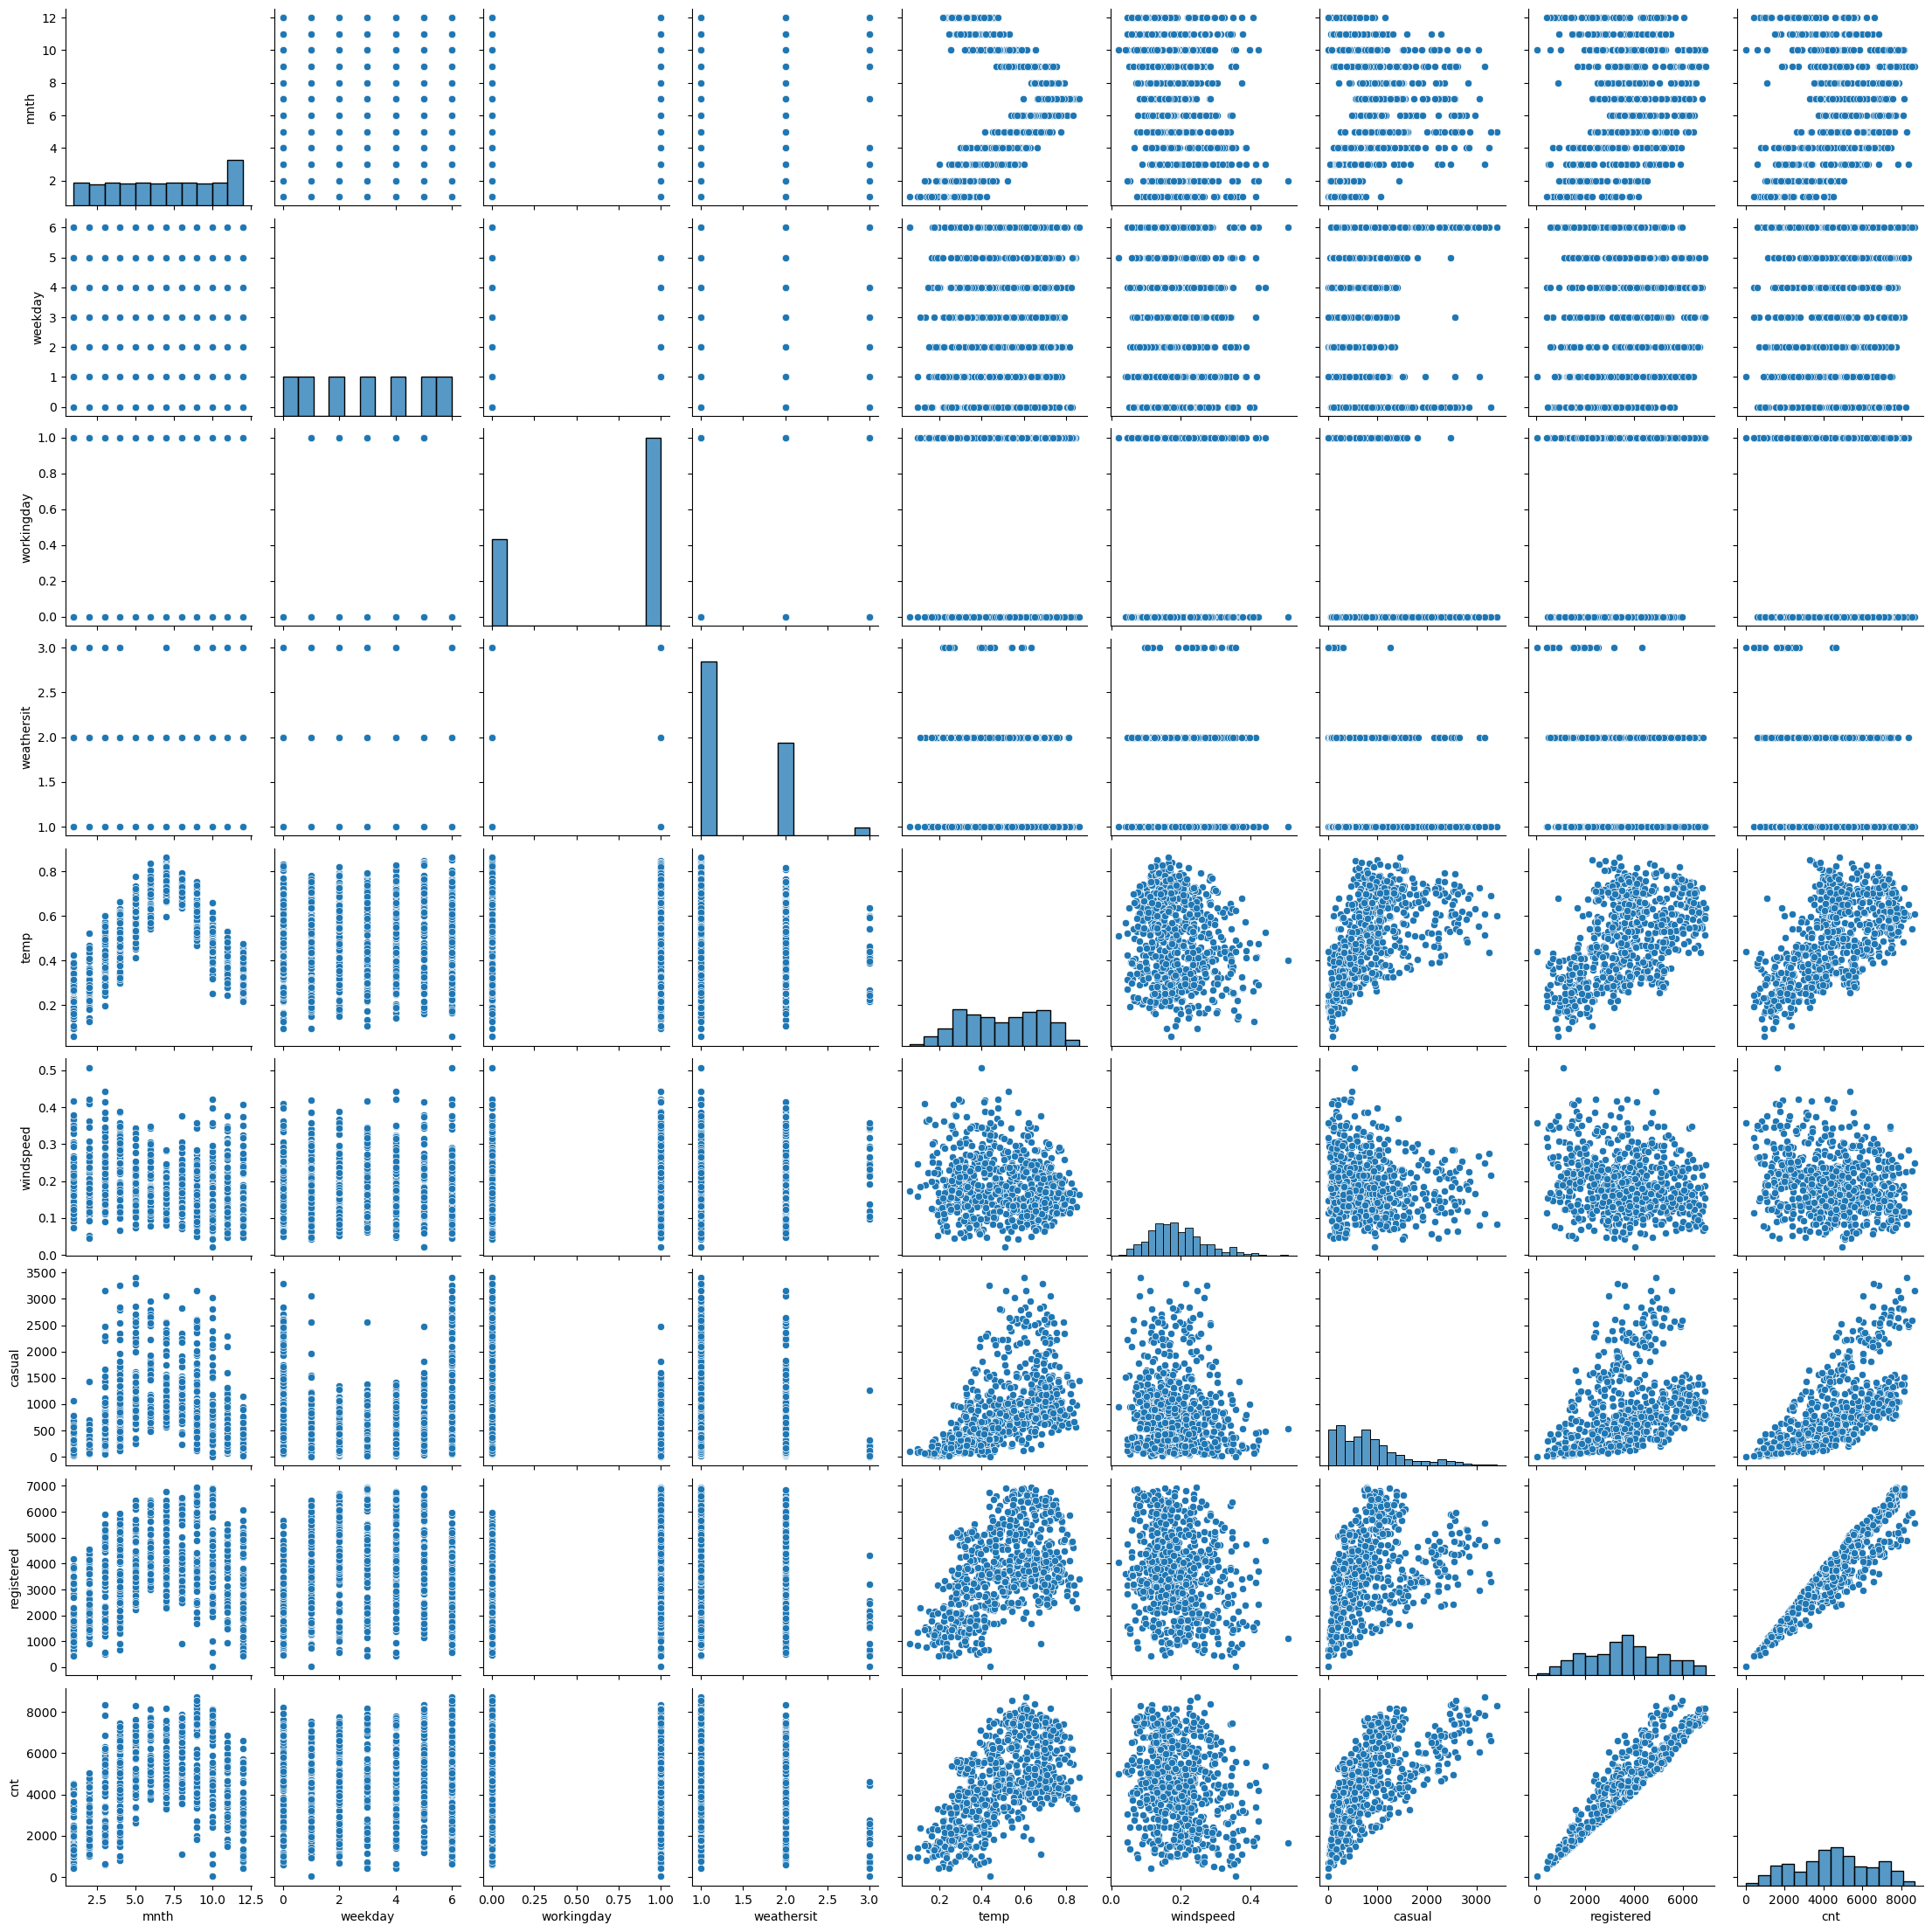

In [20]:
columns = ['mnth',	'weekday','workingday',	'weathersit',	'temp', 'windspeed',	'casual',	'registered',	'cnt']
sns.pairplot(data_final[columns])
plt.show()


Prethodni `scatter plot matrix` prikazuje drugačiji prikaz korelacije između atributa / varijabli.

---

Kao što smo ranije utvrdili, nedjelja je označena sa brojem 0 dok je subota označena sa brojem 6.

Slijedeći *boxplot* prikazuje ukupan broj iznajmljenih bicikala po danima u tjednu:

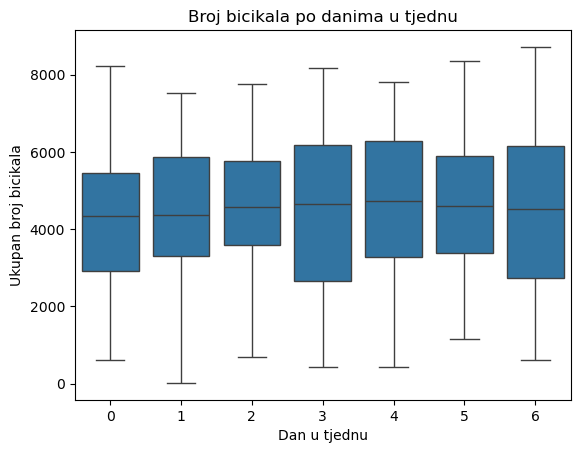

In [21]:
sns.boxplot(x='weekday', y='cnt', data=data_final)
plt.title('Broj bicikala po danima u tjednu')
plt.xlabel('Dan u tjednu')
plt.ylabel('Ukupan broj bicikala')
plt.show()

Možemo vidjeti da je ukupan broj korisnika (rekreativaca i registriranih) prilično ravnomjerno raspoređen kroz sve dane u tjednu.
Zato bi bilo korisno dodatno vizualizirati rekreativne i registrirane korisnike odvojeno.

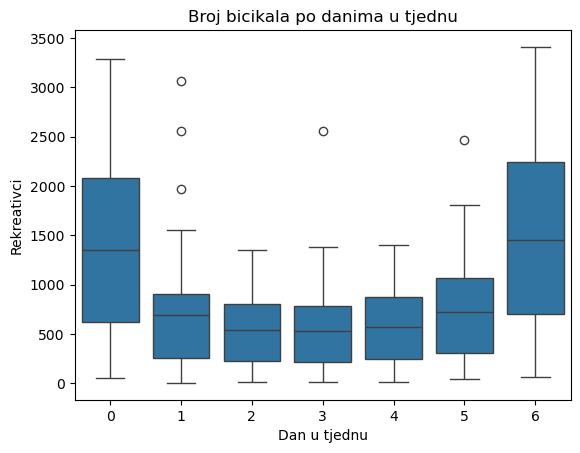

In [22]:
sns.boxplot(x='weekday', y='casual', data=data_final)
plt.title('Broj bicikala po danima u tjednu')
plt.xlabel('Dan u tjednu')
plt.ylabel('Rekreativci')
plt.show()

Sada je jasnije da se više rekreativaca vozi subotom i nedjeljom, dok ih je radnim danima znatno manje. Također, mogu se uočiti i neka stršila tijekom radnih dana, što može upućivati na praznike, neradne dane ili jednostavno jako lijepo vrijeme koje je potaknulo ljude na vožnju.

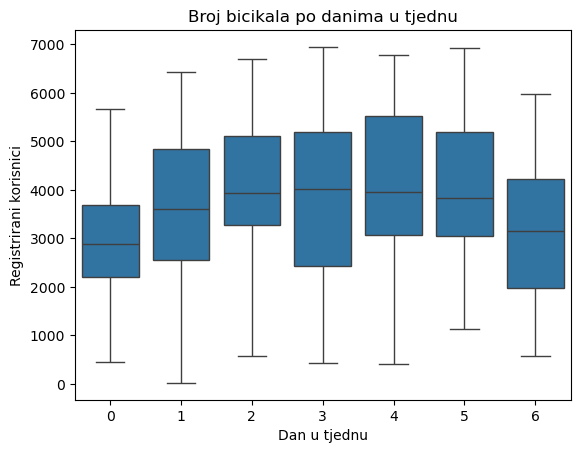

In [23]:
sns.boxplot(x='weekday', y='registered', data=data_final)
plt.title('Broj bicikala po danima u tjednu')
plt.xlabel('Dan u tjednu')
plt.ylabel('Registrirani korisnici')
plt.show()

Na dijagramu je vidljivo da je broj registriranih korisnika veći tijekom radnih dana nego vikednima, što smo mogli zaključiti i bez ovog dijagrama, ali reda radi ;-)

Sljedeći *boxplot* prikazuje broj bicikala iznajmljenih u pojedinom mjesecu:

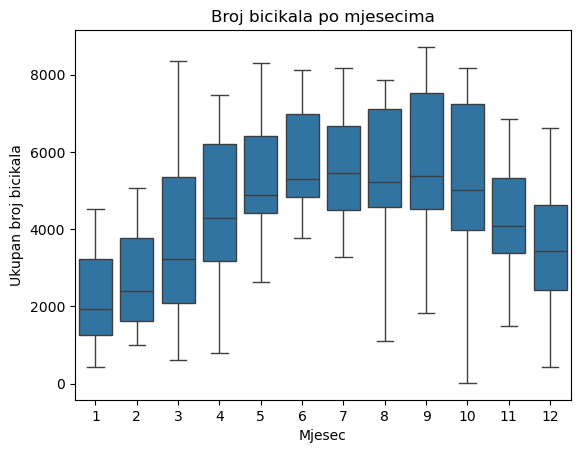

In [24]:
sns.boxplot(x='mnth', y='cnt', data=data_final)
plt.title('Broj bicikala po mjesecima')
plt.xlabel('Mjesec')
plt.ylabel('Ukupan broj bicikala')
plt.show()

Možemo zaključiti da je za vrijeme toplijih mjeseci (pred kraj proljeća, ljeto, i početak jeseni) broj korisnika veći nego za vrijeme hladnijih mjeseci.

Slijedeći *boxplot* će nam služiti da utvrdimo koja vrijednost predstavlja što za atribut `weathersit`. Pogledati ćemo za koju vrijednost ima najmanje iznajmljenih bicikala, a za koju najviše:

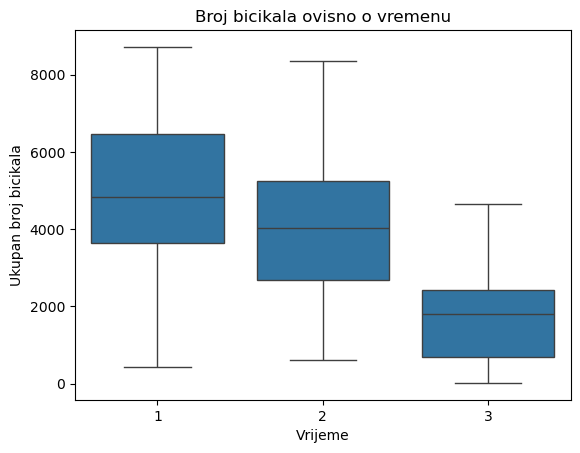

In [25]:
sns.boxplot(x='weathersit', y='cnt', data=data_final)
plt.title('Broj bicikala ovisno o vremenu')
plt.xlabel('Vrijeme')
plt.ylabel('Ukupan broj bicikala')
plt.show()

Možemo zaključiti kako vrijednost *1* predstavlja sunčano vrijeme iz razloga što ono ima najviše iznajmljenih bicikala.
- Vrijednost *2* bi predstavljala oblačno vrijeme
- Dok bi vrijednost *3* predstavljala padaline (kišovito/snježno vrijeme)

*Scatterplot* za pregled korelacije između atributa `temo` i `cnt`:

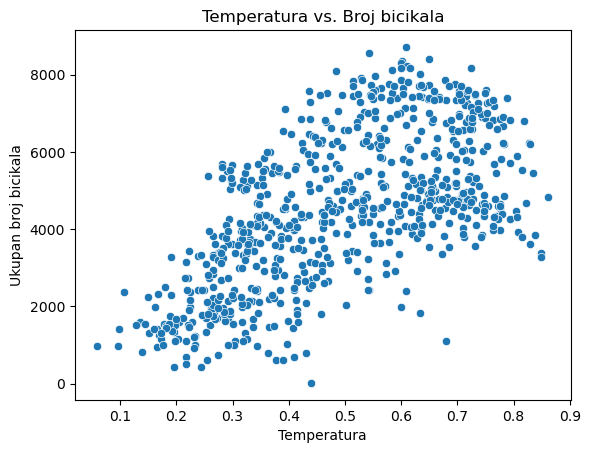

In [26]:
sns.scatterplot(x='temp', y='cnt', data=data_final)
plt.title('Temperatura vs. Broj bicikala')
plt.xlabel('Temperatura')
plt.ylabel('Ukupan broj bicikala')
plt.show()

Možemo zaključiti kako sa porastom temperature, raste i broj iznajmljenih bicikala. Također, kod najviših temperatura, broj korisnika blago opada, što i ima smilsa, te ukazuje da ova veza nije u potpunosti linearna.

---

**Histogrami**

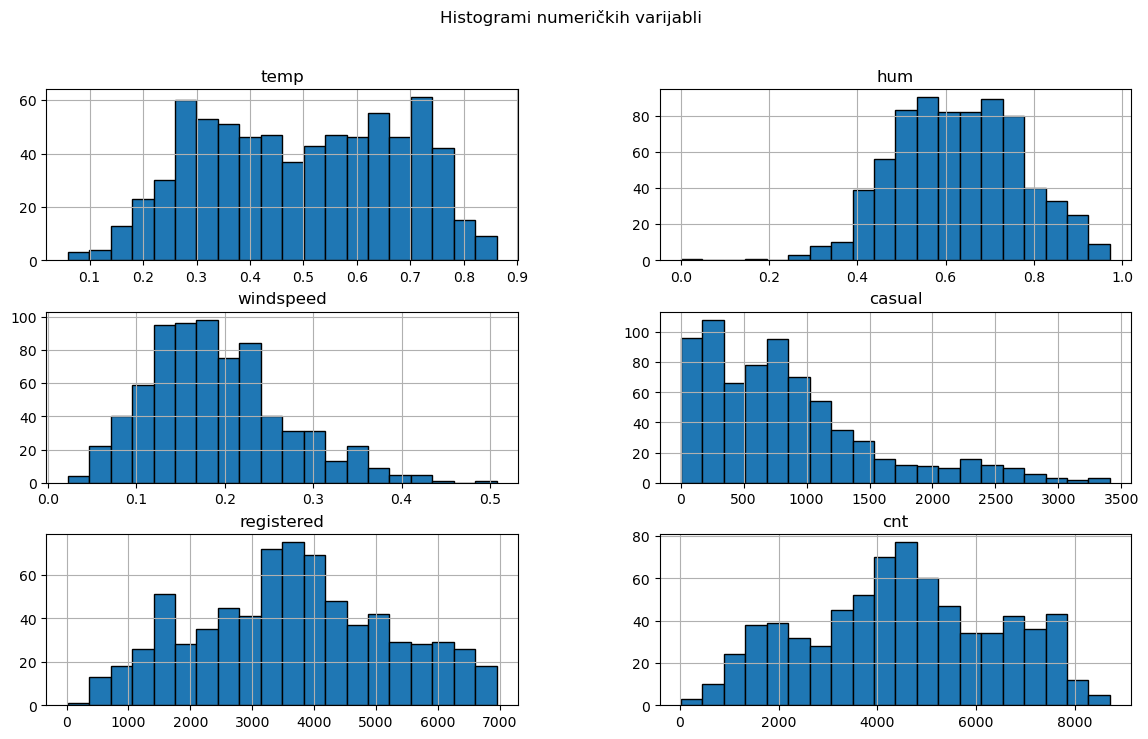

In [27]:
data_final[['temp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']].hist(bins=20, figsize=(14, 8), edgecolor='black')
plt.suptitle('Histogrami numeričkih varijabli')
plt.show()

Sa dobivenih histograma možemo zaključiti sljedeće:
- `temp` - uniformna distribucija -> većina dana s umjerenim temperaturama
- `windspeed` - desno ukošena distribucija - većina dana s laganim vjetrom, rijetko kada jako puše
- `casual` - desno ukošena / eksponencijalna distribucija -> puno je dana s malim brojem rekreativaca
- `registered` - normalna distribucija -> ukupan broj registriranih korisnika je najveći kod sredine
- `cnt` - normalna distribucija -> ukupan broj korisnika je najveći kod sredine

Text(0, 0.5, 'Broj dana')

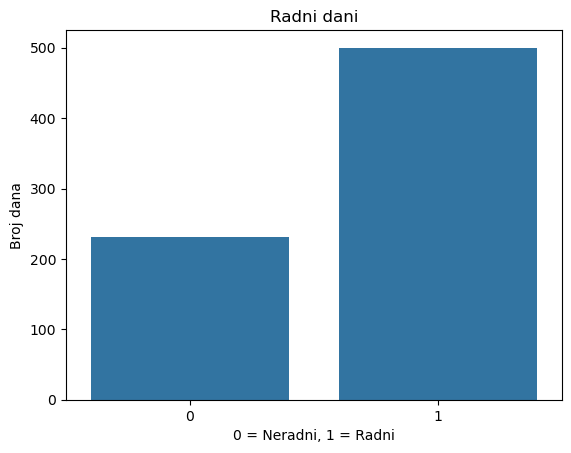

In [28]:
sns.countplot(x='workingday', data=data_final)
plt.title('Radni dani')
plt.xlabel('0 = Neradni, 1 = Radni')
plt.ylabel('Broj dana')

Prikaz raspodjele podataka za atribut `workingday` koji može biti koristan kod donošenja odluka ili za modeliranje.

Text(0, 0.5, 'Broj dana')

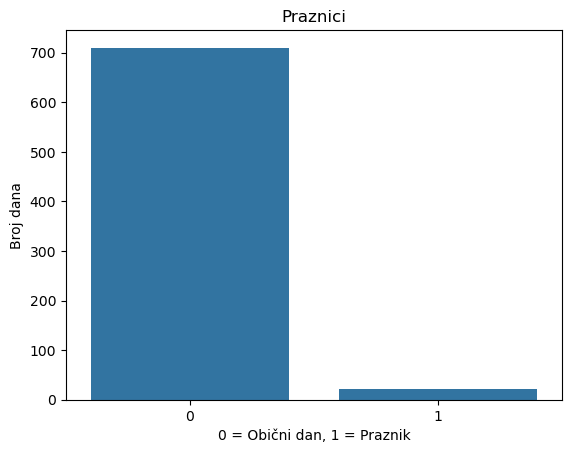

In [29]:
sns.countplot(x='holiday', data=data_final)
plt.title('Praznici')
plt.xlabel('0 = Obični dan, 1 = Praznik')
plt.ylabel('Broj dana')

Prikaz raspodjele podataka za atribut `holiday` koji može pomoći prepoznati specifične dane s drukčijim ponašanjem korisnika.

**Usporedba rekreativnih i registriranih korisnika tokom godina**

**Stacked barplot - usporeba broja rekreativnih i registriranih korisnika u određenoj godini**

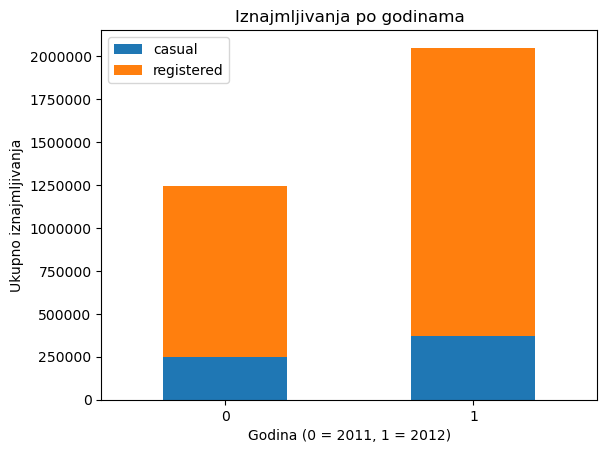

In [30]:
godine = data_final.groupby('yr')[['casual', 'registered']].sum()
godine.plot(kind='bar', stacked=True)
plt.xticks(rotation=0)
plt.ticklabel_format(style='plain', axis='y')
plt.title('Iznajmljivanja po godinama')
plt.xlabel('Godina (0 = 2011, 1 = 2012)')
plt.ylabel('Ukupno iznajmljivanja')
plt.show()

Iz grafa se vidi da je u 2012. broj iznajmljivanja skoro duplo veći nego 2011., a najviše su na to utjecali registrirani korisnici.
- > Možda su ljudi shvatili da im se više isplati biti registrirani ili je bila neka akcija pa su se odlučili prijavit?

**Stacked barplot - usporeba broja rekreativnih i registriranih korisnika u određenom danu**

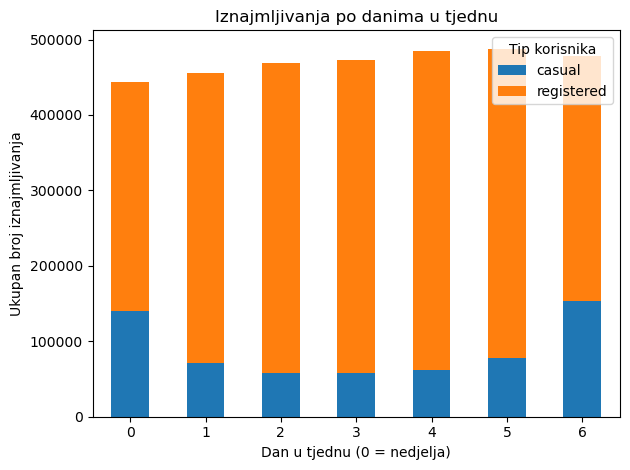

In [31]:
grouped = data_final.groupby('weekday')[['casual', 'registered']].sum()
grouped.plot(kind='bar', stacked=True)
plt.xticks(rotation=0)
plt.title('Iznajmljivanja po danima u tjednu')
plt.xlabel('Dan u tjednu (0 = nedjelja)')
plt.ylabel('Ukupan broj iznajmljivanja')
plt.legend(title='Tip korisnika')
plt.tight_layout()
plt.show()

Vikendima se više voze rekreativci, a kroz tjedan su registrirani korisnici ti koji više koriste bicikle

# **2. FAZA**

Za početak ćemo iz skupa podataka ukloniti atribut `cnt` jer je on suma od `registered` i `casual`.

- predviđati ćemo dva atributa `registered` i `casual`
- u skupu podataka se nalaze samo dvije vrijednosti za atribut `yr`
  - Atribut yr (vrijednosti 0 i 1 za 2011. i 2012.) zadržan je jer su svi modeli pokazali 15–20% veću točnost kada je uključen.
  
  - Ovo ne znači da je yr superatribut (ne otkriva izravno ciljnu vrijednost), ali je vrlo snažna značajka jer očito hvata globalni trend rasta korištenja bicikala između godina.
  
  - Zbog sezonalnosti vožnje bicikala, praktično imamo dva skupa sezonskih ciklusa (proljeće, ljeto, jesen, zima × 2), a ne dvije potpuno neovisne godine. Stoga je moguće da model ne bi znao dobro predvidjeti treću godinu, nego uči sezonske obrasce ograničene na postojeće podatke.
  
  - Ova točka ostaje otvorena za daljnju interpretaciju i dodatna testiranja generalizacije modela na buduće vremenske podatke.

In [32]:
final = data_final.drop(columns=['cnt', 'weathersit', 'holiday'])

Prikaz konačnog skupa podataka, tj. korelacijske matrice:

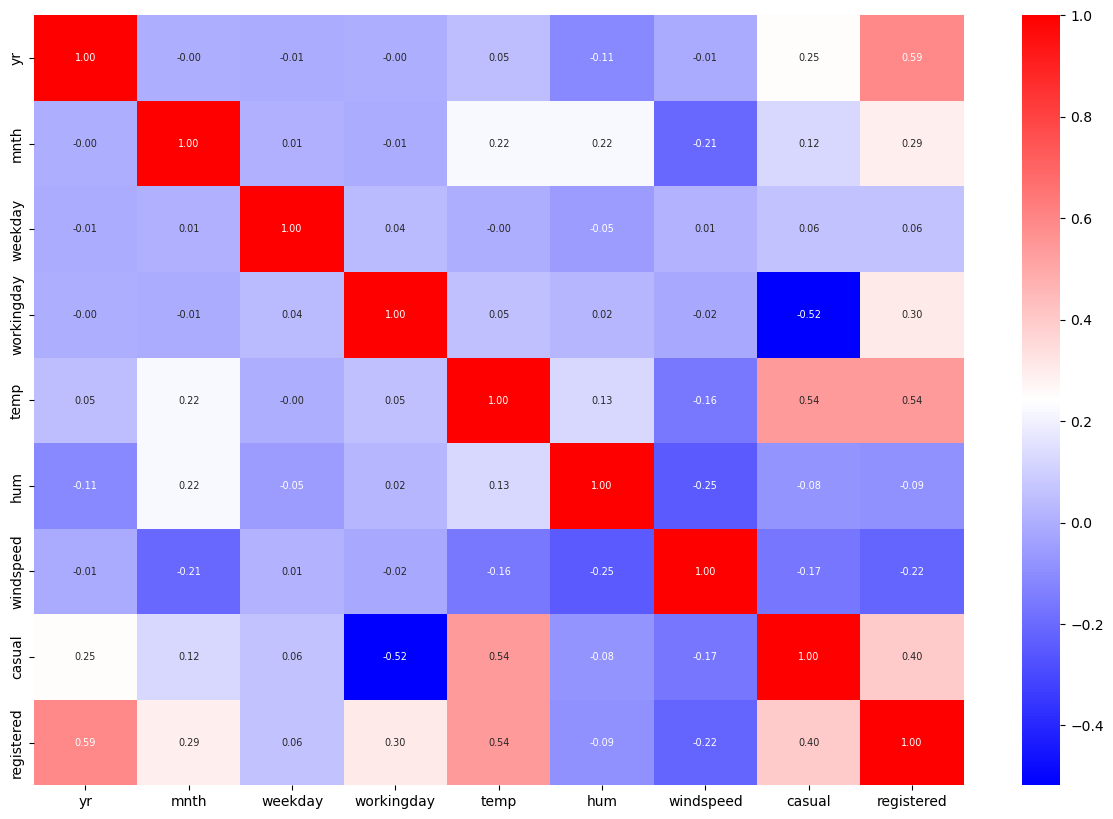

In [33]:
plt.figure(figsize=(15, 10))
sns.heatmap(final.corr(), annot=True, cmap="bwr", annot_kws={"size":7}, fmt='.2f')
plt.show()

Korelacisjka matrica prikazuje odnose konačnih atributa koji će biti korišteni u svrhu modeliranja i predviđanja

## 4. Priprema podataka

### 4.1. Odabir podataka
- Provjera multikolinearnosti i odabir značajki

Ako pogledamo prethodnu korelacijsku matricu, možemo vidjeti da se u skupu podataka ne nalaze atributi koji jako koreliraju jedan s drugim, tj. nema vrijednosti blizu +1 ili -1
- **Nema multikolinearnosti**

Kod izrade modela za predviđanje, koristit ćemo dva atributa koja ćemo predviđati (dva ciljna atributa) - `casual` i `registered`
- Imaju različite atribute koji bolje bolje doprinose predikciji:
  - `casual`:
    - `temp` -> 0.54
    - `workingday` -> -0.52
    - `windspeed` -> -0.17
    - `mnth` -> 0.12
    - `yr` -> 0.25
  - `registered`:
    - `temp` -> 0.54
    - `workingday` -> 0.30
    - `mnth` -> 0.29
    - `windspeed` -> -0.22
    - `yr` -> 0.59

In [34]:
korelacija = final.corr()['casual'].drop(['casual', 'registered'])
korelacija = korelacija.loc[korelacija.abs().sort_values(ascending=False).index]
print("Korelacije za 'casual':")
print(korelacija)

Korelacije za 'casual':
temp          0.543285
workingday   -0.518044
yr            0.248546
windspeed    -0.167613
mnth          0.123006
hum          -0.077008
weekday       0.059923
Name: casual, dtype: float64


In [35]:
korelacija = final.corr()['registered'].drop(['casual', 'registered'])
korelacija = korelacija.loc[korelacija.abs().sort_values(ascending=False).index]
print("Korelacije za 'registered':")
print(korelacija)

Korelacije za 'registered':
yr            0.594248
temp          0.540012
workingday    0.303907
mnth          0.293488
windspeed    -0.217449
hum          -0.091089
weekday       0.057367
Name: registered, dtype: float64


### 4.2. Čišćenje podataka
- Identifikacija i rješavanje problema u podacima (npr. nedostajuće vrijednosti, outlier-i) sukladno odabranoj tehnici modeliranja

Provjera nedostajućih vrijednosti:

In [36]:
final.isnull().sum()

yr            0
mnth          0
weekday       0
workingday    0
temp          0
hum           0
windspeed     0
casual        0
registered    0
dtype: int64

>Nema nedostajućih vrijednosti

Provjera outliera:

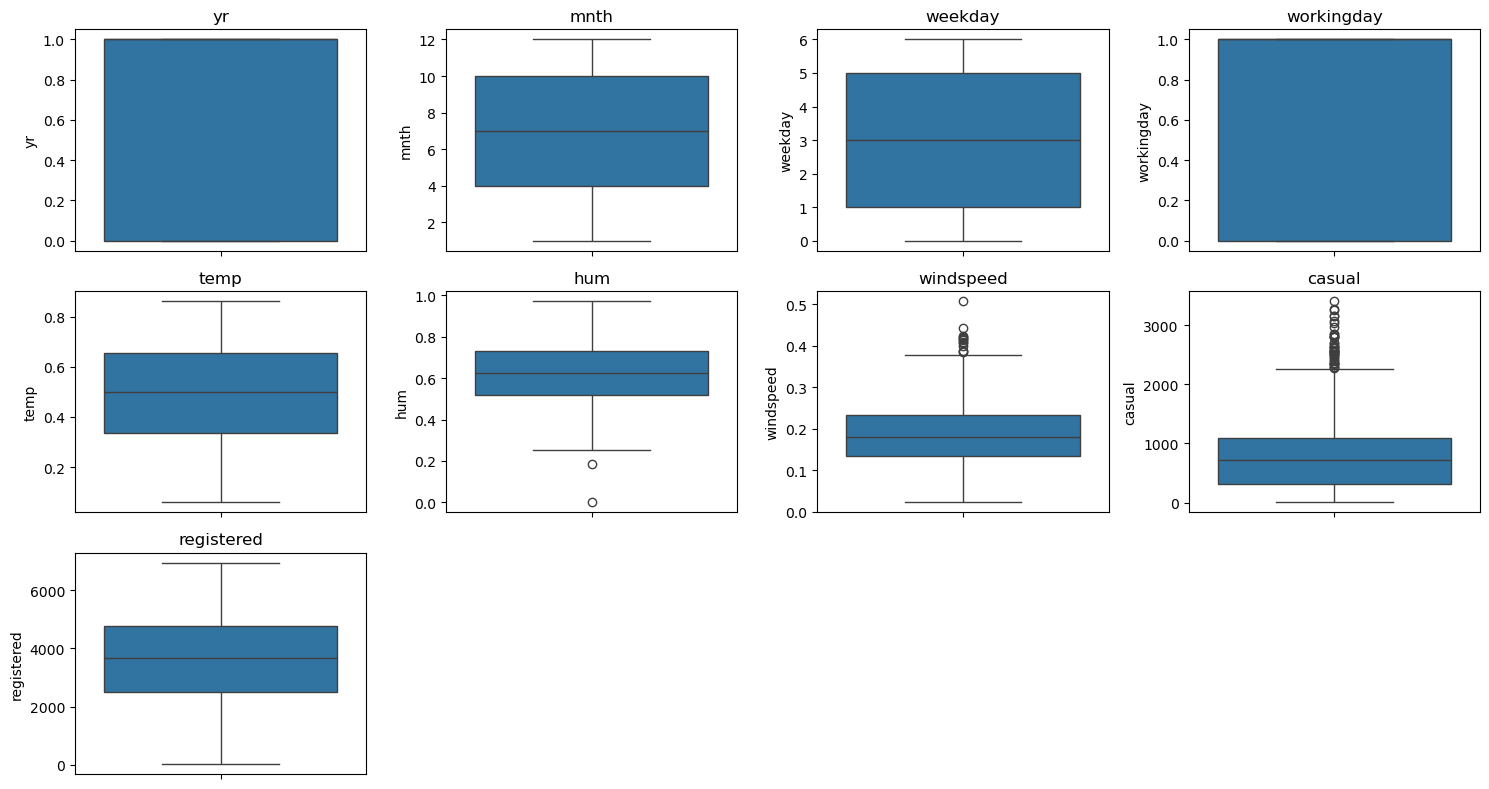

In [37]:
numerical_columns = final.select_dtypes(include = 'number').columns

plt.figure(figsize=(15, 8))
for i in range(len(numerical_columns)):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(y=numerical_columns[i], data=final)
    plt.title(numerical_columns[i])
plt.tight_layout()

`casual`:
- ciljna varijabla - outlieri se ne diraju jel postoje vrijednosti ostalih atributa koji su se rijetko javljale i rezultirale veći broj casual korisnika

`hum` i `windspeed` imaju outliere i oni se trebaju tretirati
- kod modela linearne regresije i SVR-a, isti će biti sanirani pomoću `RobustScaler-a`
- ostali modeli poput stabla odlučivanja nisu osjetljivi na outliere

### 4.3. Konstrukcija podataka
- Stvaranje novih atributa ili varijacija postojećih atributa ako je potrebno

Svi atributi su normalno konstruirani stoga stvaranje novih ili varijacija postojećih atributa nisu potrebni


Nećemo raditi dodatnu konstrukciju značajki jer su naši podaci izrazito nelinearni, a modeli poput GBR-a i Random Forest-a mogu sami prepoznati složene odnose među varijablama
- Modeli poput SVR-a i linearne regresije mogli bi imati koristi od dodatnih varijabli, no pretpostavljamo da oni ionako neće postići najbolje rezultate na ovakvom skupu podataka, za razliku od GBR-a i Random Forest-a koji su prikladniji za ovakve situacije

### 4.4. Integriranje podataka
- Spajanje više izvora podataka u jedan integritetan skup podataka ako je potrebno

Koristimo jedan izvor podataka stoga za ovu točku nije potrebno ništa raditi

### 4.5. Oblikovanje podataka
- Priprema podataka za analizu i modeliranje (npr. skaliranje, kodiranje, tranformacije značajki)

In [38]:
print(final.dtypes)

yr              int64
mnth            int64
weekday         int64
workingday      int64
temp          float64
hum           float64
windspeed     float64
casual          int64
registered      int64
dtype: object


In [39]:
final.head(20)

,yr,mnth,weekday,workingday,temp,hum,windspeed,casual,registered
0,0,1,6,0,0.344167,0.805833,0.160446,331,654
1,0,1,0,0,0.363478,0.696087,0.248539,131,670
2,0,1,1,1,0.196364,0.437273,0.248309,120,1229
3,0,1,2,1,0.200000,0.590435,0.160296,108,1454
4,0,1,3,1,0.226957,0.436957,0.186900,82,1518
5,0,1,4,1,0.204348,0.518261,0.089565,88,1518
6,0,1,5,1,0.196522,0.498696,0.168726,148,1362
7,0,1,6,0,0.165000,0.535833,0.266804,68,891
8,0,1,0,0,0.138333,0.434167,0.361950,54,768
9,0,1,1,1,0.150833,0.482917,0.223267,41,1280


Kao što je utvrđeno u prvoj fazi - sve vrijednosti su transormirane, kodirane i normalizirane. Nema potrebe ništa raditi kod ove točke
- Stršila kod atributa `hum` i `windspeed` biti će dodatno skalirane pomoću **RobustScaler-a** kod modela koji su osjetljivi na njih (SVR, i linearna regresija (OSL))

## 5. Modeliranje

### 5.1. Odabir tehnike modeliranja
- Kratki opis i argumentiranje odabira tehnike modeliranje

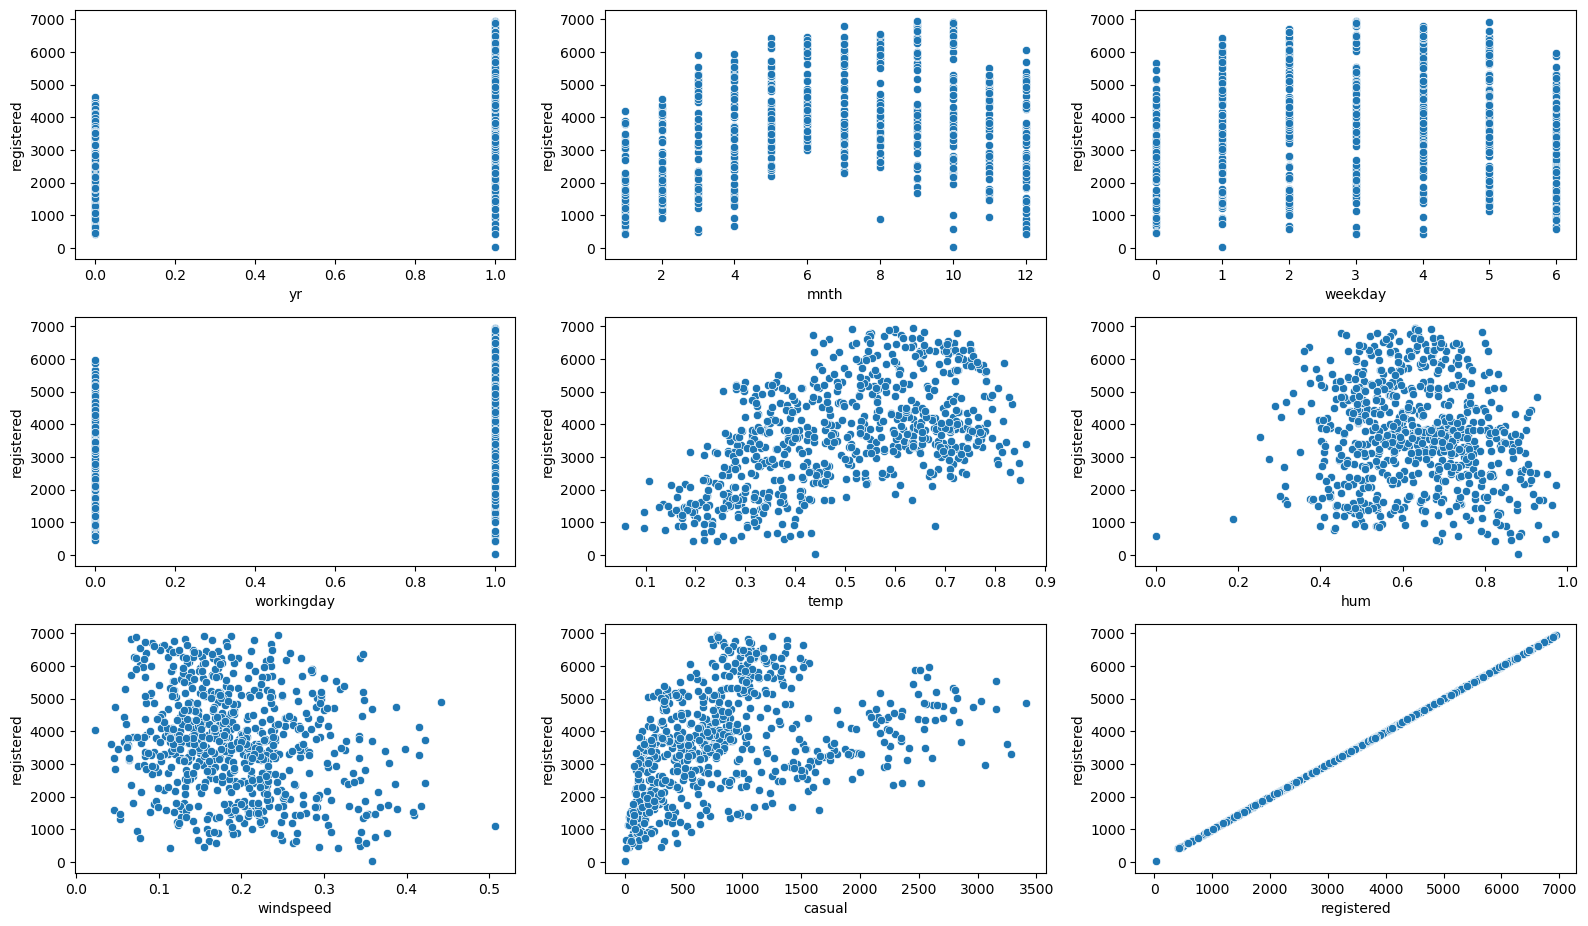

In [40]:
target = 'registered'
features = final.columns

plt.figure(figsize=(16, 12))
for i, feature in enumerate(features, 1):
    plt.subplot(4, 3, i)
    sns.scatterplot(x=final[feature], y=final[target])
plt.tight_layout()
plt.show()


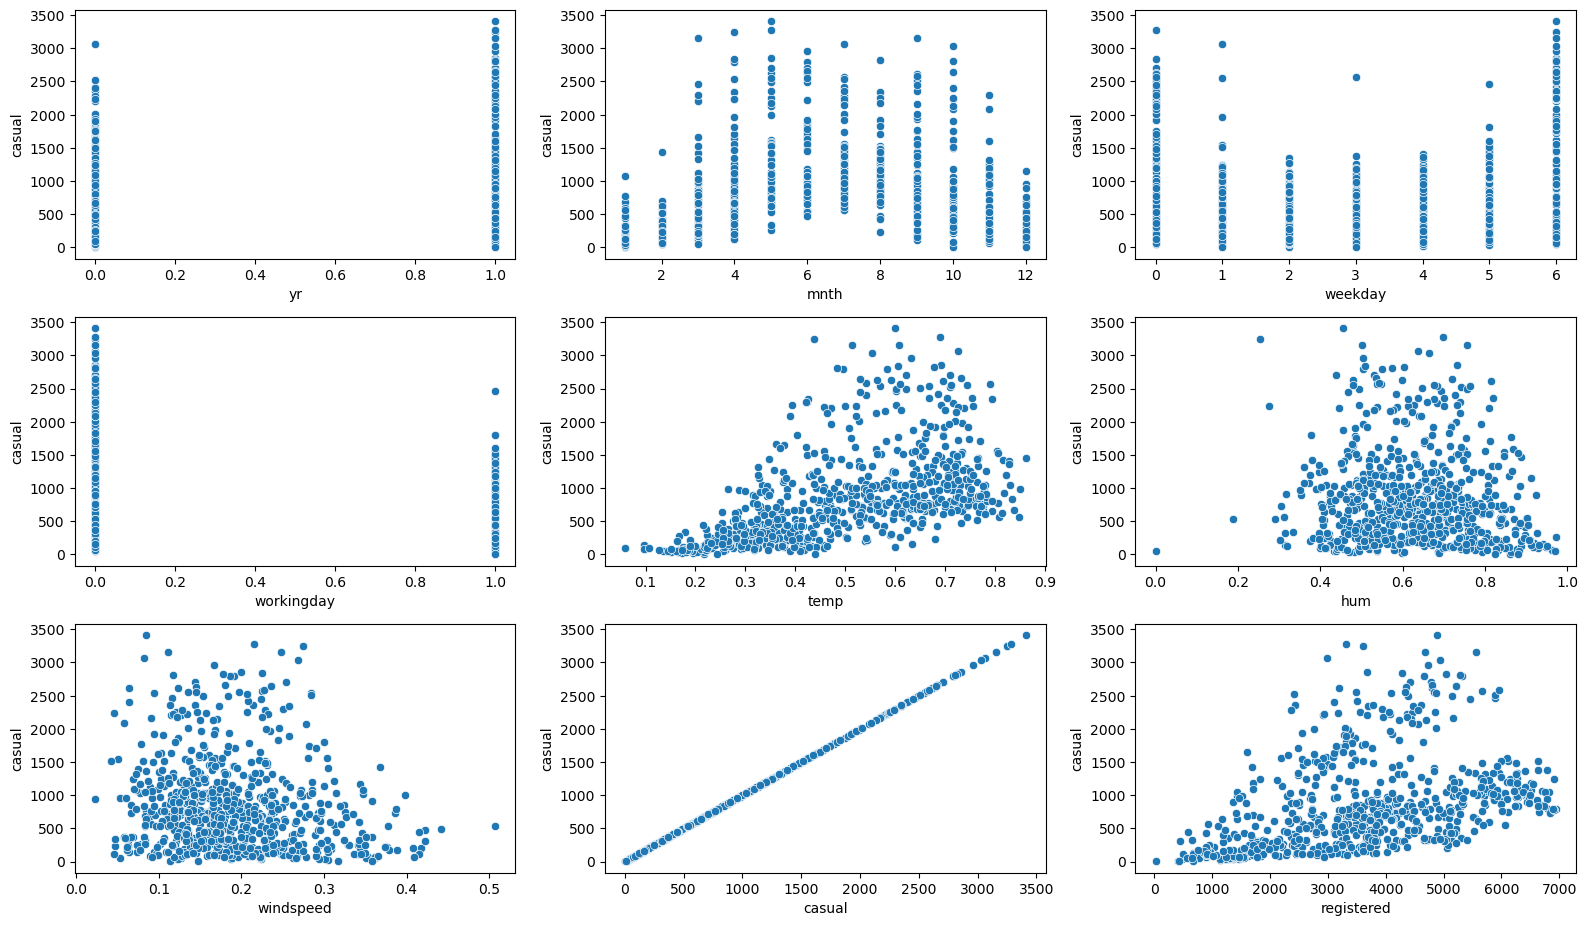

In [41]:
target = 'casual'
features = final.columns

plt.figure(figsize=(16, 12))
for i, feature in enumerate(features, 1):
    plt.subplot(4, 3, i)
    sns.scatterplot(x=final[feature], y=final[target])
plt.tight_layout()
plt.show()

Većina značajki je nelinearno povezana - izuzetak je značajka temp koja blako pokazuje linearnu povezanost sa ciljnim varijablama `casual` i `registered`
- kod visokih temperatura broj aktivnih korisnika opada

U svrhu ovog projekta, odabrali smo sljedeće model:
- Linearna regresija (OSL)
- Support Vector Regression (SVR)
- Random Forest
- Gradient Boosting

Odlučili smo se za više modela kako bi mogli ustanoviti koji model je najprikladniji za naš skup podataka, te naš problem regresije
- Pretpostavka: Modeli Random Forest i Gradient Boosting dati će bolje rezultate predviđana jer su oni bolje hvataju nelinearne i kompleksne odnose između varijabli

Za usporedbu smo odlučili i napraviti modele OSL i SVR jer želimo vidjeli koliko "linearniji" modeli zaostaju u odnosu na "nelinearne"  

U svrhu definiranja pojedinih modela, korištene su informacije sa sljedeće stranice: https://scikit-learn.org/stable/supervised_learning.html

**Linearna regresije (OSL)** je najjednostavniji model koji pokušava pronaći ravnu liniju kroz podatke kako bi predvidio rezultat
- S njom smo odlučili krenuti jer je brza i laka za razumjet, te će služiti kao dobra usporedba za ostale složenije modele
  - Najbolje rezultate postiže kada postoji linearni odnos između značajki i ciljne varijable, što je vidljivo kod značajke `temp`, ali s obzirom na to da većina ostalih značajki pokazuje nelinearnu povezanost, očekujemo da ovaj model neće dati najbolje rezultate (https://scikit-learn.org/stable/modules/linear_model.html#ordinary-least-squares)

**Support Vector Regression (SVR)** je model koji pokušava pronaći funkciju koja predviđa ciljne vrijednosit tako da većina podataka bude unutar dopuštene pogreške (epsilon)
- Odlučili smo isprobati ovaj model jer se može nositi i s linearnim i s nelinearnim odnosima
  - Budući da naš skup podataka sadrži dosta nelinearnih odnosa, SVR bi mogao bolje prilagoditi podatke od linearne regresije
    - Moramo biti oprezni na outliere jer je model osjetljiv na njih
- Prilikom definiranja modela, potrebno je podesiti sljedeće parametre:
  - *kernel* - određuje kako model pretvara podatke da bi pronašao nelinearne veze
  - *C* - kažnjava pogreške - veći C znači da model pokušava biti točniji, alo može overfitati
  - *epsilon* - definira zonu tolerancije oko stvane vrijednosti u kojoj model ne kažnjava pogreške
(https://scikit-learn.org/stable/modules/svm.html#svr)

**Random Forest** je model koji kombinira više stabla odlučivanja treniranih na različitim podskupovima podataka, a konačna predikcija je prosjek njihovih rezultata
- Odabrali smo ovaj model jer se jako dobro nosi s nealinearnim podacima, nije osjetljiv na outliere i ne zahtijeva skaliranje značajki
  - S obzirom na to da naš skup podataka ima mješavinu skaliranih i kategorijskih varijabli te dosta nelinearnih odnosa, ovaj model bi mogao dati jako dobre rezultate (https://scikit-learn.org/stable/modules/ensemble.html#random-forests)

**Gradient Boosting Regressor** je model koji pripada u skupinu algoritma naziva Boosted Trees koji sekvencijalno grade stabla fokusirajući se na primjere koji su pogrešno klasificirani
- Ovaj model je poznat po svojoj visokoj točnosti i dobroj prilagodbi podacima, posebno kada postoji više nelinearnih odnosa
  - Zbog toga što naš skup podataka pokazuje malo složenije veze među varijablama, očekujemo da bi Gradient Boosting mogao ostaviri jedan od najboljih rezultata, ako ga pravilno podesimo, tj. optimiziramo (https://scikit-learn.org/stable/modules/ensemble.html#gradient-boosting)

### 5.2. Dizajn testiranja
- Planiranje strategije testiranja modela (križna validacija ili druge metode particioniranja podataka)

Za testiranje model koristili smo kombinaciju particioniranja podataka (80-20) i križnu validaciju.

Podaci su particionirani pomoću funkcije `train_test_split`, gdje je 80% uzoraka korišteno za treniranje, a 20% za testiranje.

Osim toga, prilikom pretraživanja najboljih parametara pomoću `RandomizedSearchCV` koristili smo križnu validaciju (*cv=5*) kako bismo dobili stabilniju procjenu performansi modela i smanjili utjecaj slučajne podjele podataka. Skup podataka dijeli se na 5 dijelova, i model se trenira 5 puta tako da svaki put koristi 4 dijela za učenje i 1 za testiranje, a konačan rezultat je prosjek tih 5 rezultata
- Ova križna validacija će biti korištena kod:
  - `GradientBoostingRegressor`
  - `RandomForestRegressor`

### 5.3. Izgradnja modela
- Implementacija odabranih modela

Za početak je potrebno podijeliti podatke na skup za treniranje i skup za testiranje

In [42]:
X = final.drop(['registered', 'casual'],axis=1)
y = final[['registered', 'casual']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1) # particioniranje podataka 80-20 (treniranje-testiranje)

In [43]:
robust=RobustScaler()                       # Za SVR i OSL

X_train_robust=robust.fit_transform(X_train)
X_test_robust=robust.transform(X_test)
y_pred = {}

#### 5.3.1. Linearna regresija (OSL)

In [44]:
# Definiranje i treniranje modela
modelLinReg = MultiOutputRegressor(LinearRegression())
modelLinReg.fit(X_train_robust, y_train)

MultiOutputRegressor(estimator=LinearRegression())

In [45]:
# Predikcija
y_pred['LinReg'] = modelLinReg.predict(X_test_robust)

In [46]:
# Evaluacija modela
pred = y_pred['LinReg']

print(f"MSE Registered: {mean_squared_error(y_test['registered'], pred[:, 0]):.2f}")
print(f"MAE Registered: {mean_absolute_error(y_test['registered'], pred[:, 0]):.2f}")
print(f"R^2 Registered: {r2_score(y_test['registered'], pred[:, 0]):.2f}")
print("------------------------")
print(f"MSE Casual: {mean_squared_error(y_test['casual'], pred[:, 1]):.2f}")
print(f"MAE Casual: {mean_absolute_error(y_test['casual'], pred[:, 1]):.2f}")
print(f"R^2 Casual: {r2_score(y_test['casual'], pred[:, 1]):.2f}")

MSE Registered: 572216.44
MAE Registered: 539.07
R^2 Registered: 0.77
------------------------
MSE Casual: 167929.63
MAE Casual: 292.54
R^2 Casual: 0.59


Model bolje predviđa registrirane korisnike nego rekreativne korisnik. Razlog k tomu je što postoji linearna veza sa atributima temp i yr i registered

#### 5.3.2. Support Vector Regression (SVR)

In [47]:
# Definiranje modela i treniranje
modelSVR = MultiOutputRegressor(SVR(kernel='rbf', C=100, epsilon=0.1))
modelSVR.fit(X_train_robust, y_train)

MultiOutputRegressor(estimator=SVR(C=100))

In [48]:
# Predikcija
y_pred['SVR'] = modelSVR.predict(X_test_robust)

In [49]:
# Evaluacija modela
pred = y_pred['SVR']

print(f"MSE Registered: {mean_squared_error(y_test['registered'], pred[:, 0]):.2f}")
print(f"MAE Registered: {mean_absolute_error(y_test['registered'], pred[:, 0]):.2f}")
print(f"R^2 Registered: {r2_score(y_test['registered'], pred[:, 0]):.2f}")
print("------------------------")
print(f"MSE Casual: {mean_squared_error(y_test['casual'], pred[:, 1]):.2f}")
print(f"MAE Casual: {mean_absolute_error(y_test['casual'], pred[:, 1]):.2f}")
print(f"R^2 Casual: {r2_score(y_test['casual'], pred[:, 1]):.2f}")

MSE Registered: 478896.39
MAE Registered: 487.08
R^2 Registered: 0.81
------------------------
MSE Casual: 103993.18
MAE Casual: 197.20
R^2 Casual: 0.75


SVR model ima bolju točnost predviđanja u odnosu na linearnu regresiju (R^2 je veći za 0.20) za registrirane korisnike. Što se tiće rekreativnih korisnika, točnost predviđanja je značajno bolja u odnosu na točnost predviđanja linearne regresije. Također, prosječna pogreška po predviđanju je manja kod SVR-a u odnosu na linearnu regresiju, što i ima smisla s obzirom da je i točnost veća.

#### 5.3.3. Random Forest

In [50]:
# Definiranje modela
modelRFR = MultiOutputRegressor(RandomForestRegressor(random_state=11))
modelRFR.fit(X_train, y_train)                      # Model dobro barata sa stršilima - nisu potrebni skalirani podaci

MultiOutputRegressor(estimator=RandomForestRegressor(random_state=11))

In [51]:
# Predikcija
y_pred['RFR'] = modelRFR.predict(X_test)

In [52]:
# Evaluacija
pred = y_pred['RFR']

print(f"MSE Registered: {mean_squared_error(y_test['registered'], pred[:, 0]):.2f}")
print(f"MAE Registered: {mean_absolute_error(y_test['registered'], pred[:, 0]):.2f}")
print(f"R^2 Registered: {r2_score(y_test['registered'], pred[:, 0]):.2f}")
print("------------------------")
print(f"MSE Casual: {mean_squared_error(y_test['casual'], pred[:, 1]):.2f}")
print(f"MAE Casual: {mean_absolute_error(y_test['casual'], pred[:, 1]):.2f}")
print(f"R^2 Casual: {r2_score(y_test['casual'], pred[:, 1]):.2f}")

MSE Registered: 304086.54
MAE Registered: 379.87
R^2 Registered: 0.88
------------------------
MSE Casual: 78170.54
MAE Casual: 191.24
R^2 Casual: 0.81


Vidljiva je značajna promjena točnosti i kod registriranih i kod rekreativnih korisnika - što upućuje da je naša početna pretpostavka da će modeli bazirani na stablu odlučivanja dati bolje rezultate.

#### 5.3.4.  Gradient Boosting Regressor

In [53]:
# Definicija modela
modelGBR = MultiOutputRegressor(GradientBoostingRegressor(random_state=11))
modelGBR.fit(X_train, y_train)

MultiOutputRegressor(estimator=GradientBoostingRegressor(random_state=11))

In [54]:
# Predikcija
y_pred['GBR'] = modelGBR.predict(X_test)

In [55]:
# Evaluacija
pred = y_pred['GBR']

print(f"MSE Registered: {mean_squared_error(y_test['registered'], pred[:, 0]):.2f}")
print(f"MAE Registered: {mean_absolute_error(y_test['registered'], pred[:, 0]):.2f}")
print(f"R^2 Registered: {r2_score(y_test['registered'], pred[:, 0]):.2f}")
print("------------------------")
print(f"MSE Casual: {mean_squared_error(y_test['casual'], pred[:, 1]):.2f}")
print(f"MAE Casual: {mean_absolute_error(y_test['casual'], pred[:, 1]):.2f}")
print(f"R^2 Casual: {r2_score(y_test['casual'], pred[:, 1]):.2f}")

MSE Registered: 278142.28
MAE Registered: 375.75
R^2 Registered: 0.89
------------------------
MSE Casual: 94923.40
MAE Casual: 200.86
R^2 Casual: 0.77


Model GBR je dao skoro identične evaluacijske rezultate kao i RFR model

### 5.4. Procjena modela

#### 5.4.1. Optimizacija hiperparametara

In [56]:
modelGBR.get_params()

{'estimator__alpha': 0.9,
 'estimator__ccp_alpha': 0.0,
 'estimator__criterion': 'friedman_mse',
 'estimator__init': None,
 'estimator__learning_rate': 0.1,
 'estimator__loss': 'squared_error',
 'estimator__max_depth': 3,
 'estimator__max_features': None,
 'estimator__max_leaf_nodes': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 100,
 'estimator__n_iter_no_change': None,
 'estimator__random_state': 11,
 'estimator__subsample': 1.0,
 'estimator__tol': 0.0001,
 'estimator__validation_fraction': 0.1,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': GradientBoostingRegressor(random_state=11),
 'n_jobs': None}

Kao što je i prethodno navedeno, koristiti će se `RandomizedSearchCV` za optimizaciju hiperparametara
- *RandomizedSearchCV* je metoda za podešavanje hiperparametara modela koja nasumično isprobava kombinacije umjesto da prolazi kroz sve moguće

##### 5.4.1.1. Random Forest

In [57]:
modelRFR.get_params()

{'estimator__bootstrap': True,
 'estimator__ccp_alpha': 0.0,
 'estimator__criterion': 'squared_error',
 'estimator__max_depth': None,
 'estimator__max_features': 1.0,
 'estimator__max_leaf_nodes': None,
 'estimator__max_samples': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__monotonic_cst': None,
 'estimator__n_estimators': 100,
 'estimator__n_jobs': None,
 'estimator__oob_score': False,
 'estimator__random_state': 11,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': RandomForestRegressor(random_state=11),
 'n_jobs': None}

In [58]:
help(RandomForestRegressor)

Help on class RandomForestRegressor in module sklearn.ensemble._forest:

class RandomForestRegressor(ForestRegressor)
 |  RandomForestRegressor(n_estimators=100, *, criterion='squared_error', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=1.0, max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, ccp_alpha=0.0, max_samples=None, monotonic_cst=None)
 |
 |  A random forest regressor.
 |
 |  A random forest is a meta estimator that fits a number of decision tree
 |  regressors on various sub-samples of the dataset and uses averaging to
 |  improve the predictive accuracy and control over-fitting.
 |  Trees in the forest use the best split strategy, i.e. equivalent to passing
 |  `splitter="best"` to the underlying :class:`~sklearn.tree.DecisionTreeRegressor`.
 |  The sub-sample size is controlled with the `max_samples` parameter if
 |  `bootstrap=Tru

In [59]:
# Definiranje parametara za pretragu
params_grid = {
    'estimator__n_estimators': [50, 100, 200],
    'estimator__max_depth': [None, 5, 10, 20],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 4],
    'estimator__max_features': ['sqrt', 'log2'],
    'estimator__bootstrap': [True, False]
}

Prevelika dubina stabla i premali broj uzoraka za podjelu mogu dovesti do pretreniranosti. Zbog toga smo koristili max_depth u rasponu od 5 do 20, min_samples_split u rasponu od 2 do 10 te min_samples_leaf od 1 do 5, kako bi ograničili kompleksnost stabla i spriječili da model nauči šum u podacima

In [60]:
# Kreiranje instance RandomizedSearchCV
random_search = RandomizedSearchCV(modelRFR, params_grid, n_iter=50, verbose=1, cv=5, refit=True, random_state=14, n_jobs=-1)

# Treniranje s RandomizedSearchCV
random_search.fit(X_train, y_train)

# Ispis najboljih parametara
best_params = random_search.best_params_
print("Najbolji parametri:", best_params)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Najbolji parametri: {'estimator__n_estimators': 200, 'estimator__min_samples_split': 2, 'estimator__min_samples_leaf': 2, 'estimator__max_features': 'log2', 'estimator__max_depth': 20, 'estimator__bootstrap': False}


In [61]:
random_search.best_estimator_

MultiOutputRegressor(estimator=RandomForestRegressor(bootstrap=False,
                                                     max_depth=20,
                                                     max_features='log2',
                                                     min_samples_leaf=2,
                                                     n_estimators=200,
                                                     random_state=11))

In [62]:
RFR_best = random_search.best_estimator_

In [63]:
y_pred['RFR_best'] = RFR_best.predict(X_test)
pred = y_pred['RFR_best']
print(f"MSE Registered: {mean_squared_error(y_test['registered'], pred[:, 0]):.2f}")
print(f"MAE Registered: {mean_absolute_error(y_test['registered'], pred[:, 0]):.2f}")
print(f"R^2 Registered: {r2_score(y_test['registered'], pred[:, 0]):.2f}")
print("------------------------")
print(f"MSE Casual: {mean_squared_error(y_test['casual'], pred[:, 1]):.2f}")
print(f"MAE Casual: {mean_absolute_error(y_test['casual'], pred[:, 1]):.2f}")
print(f"R^2 Casual: {r2_score(y_test['casual'], pred[:, 1]):.2f}")

MSE Registered: 330653.49
MAE Registered: 408.72
R^2 Registered: 0.87
------------------------
MSE Casual: 81666.20
MAE Casual: 192.03
R^2 Casual: 0.80


Evaluacijski rezultati optimiziranog modela Random Forest su jednaki rezultatu modela i prije optimizacije - upućuje da je model sam po sebi dovoljno optimiziran te da nema potrebe za dodatnom optimizacijom

##### 5.4.1.2. Gradient Boosting Regressor

In [64]:
modelGBR.get_params()

{'estimator__alpha': 0.9,
 'estimator__ccp_alpha': 0.0,
 'estimator__criterion': 'friedman_mse',
 'estimator__init': None,
 'estimator__learning_rate': 0.1,
 'estimator__loss': 'squared_error',
 'estimator__max_depth': 3,
 'estimator__max_features': None,
 'estimator__max_leaf_nodes': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 100,
 'estimator__n_iter_no_change': None,
 'estimator__random_state': 11,
 'estimator__subsample': 1.0,
 'estimator__tol': 0.0001,
 'estimator__validation_fraction': 0.1,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': GradientBoostingRegressor(random_state=11),
 'n_jobs': None}

In [65]:
help(RandomForestRegressor)

Help on class RandomForestRegressor in module sklearn.ensemble._forest:

class RandomForestRegressor(ForestRegressor)
 |  RandomForestRegressor(n_estimators=100, *, criterion='squared_error', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=1.0, max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, ccp_alpha=0.0, max_samples=None, monotonic_cst=None)
 |
 |  A random forest regressor.
 |
 |  A random forest is a meta estimator that fits a number of decision tree
 |  regressors on various sub-samples of the dataset and uses averaging to
 |  improve the predictive accuracy and control over-fitting.
 |  Trees in the forest use the best split strategy, i.e. equivalent to passing
 |  `splitter="best"` to the underlying :class:`~sklearn.tree.DecisionTreeRegressor`.
 |  The sub-sample size is controlled with the `max_samples` parameter if
 |  `bootstrap=Tru

In [66]:
# Definiranje parametara za pretragu za Gradient Boosting
params_grid = {
    'estimator__n_estimators': np.arange(100, 501, 50),         
    'estimator__learning_rate': [0.01, 0.05, 0.1, 0.2],         
    'estimator__max_depth': np.arange(3, 11),                  
    'estimator__min_samples_split': np.arange(2, 11),       
    'estimator__min_samples_leaf': np.arange(1, 6),          
    'estimator__subsample': [0.6, 0.8, 1.0],                 
    'estimator__criterion': ['squared_error', 'friedman_mse']  
}

In [67]:
# Kreiranje instance RandomizedSearchCV
random_search = RandomizedSearchCV(modelGBR, params_grid, n_iter=50, verbose=1, cv=5, refit=True, random_state=20, n_jobs=-1)

# Treniranje s RandomizedSearchCV
random_search.fit(X_train, y_train)

# Ispis najboljih parametara
best_params = random_search.best_params_
print("Najbolji parametri:", best_params)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Najbolji parametri: {'estimator__subsample': 0.6, 'estimator__n_estimators': 400, 'estimator__min_samples_split': 3, 'estimator__min_samples_leaf': 4, 'estimator__max_depth': 4, 'estimator__learning_rate': 0.05, 'estimator__criterion': 'friedman_mse'}


In [68]:
random_search.best_estimator_

MultiOutputRegressor(estimator=GradientBoostingRegressor(learning_rate=0.05,
                                                         max_depth=4,
                                                         min_samples_leaf=4,
                                                         min_samples_split=3,
                                                         n_estimators=400,
                                                         random_state=11,
                                                         subsample=0.6))

In [69]:
GBR_best = random_search.best_estimator_ # pohranjuje najbolji model pronađen kroz RandomizedSearchCV u varijablu GBR_best

In [70]:
y_pred['GBR_best'] = GBR_best.predict(X_test)
pred = y_pred['GBR_best']
print(f"MSE Registered: {mean_squared_error(y_test['registered'], pred[:, 0]):.2f}")
print(f"MAE Registered: {mean_absolute_error(y_test['registered'], pred[:, 0]):.2f}")
print(f"R^2 Registered: {r2_score(y_test['registered'], pred[:, 0]):.2f}")
print("------------------------")
print(f"MSE Casual: {mean_squared_error(y_test['casual'], pred[:, 1]):.2f}")
print(f"MAE Casual: {mean_absolute_error(y_test['casual'], pred[:, 1]):.2f}")
print(f"R^2 Casual: {r2_score(y_test['casual'], pred[:, 1]):.2f}")

MSE Registered: 293447.31
MAE Registered: 370.43
R^2 Registered: 0.88
------------------------
MSE Casual: 75889.83
MAE Casual: 180.50
R^2 Casual: 0.81


GBR model nakon optimizacije daje nešto bolju točnost predviđanja za rekreativne korisnike, dok je točnost predikcija za registered korisnike identična

#### 5.4.2. Evaluacija performansi

In [71]:
for name, pred in y_pred.items():
    print(f"Model: {name}")
    print(f"MSE Registered: {mean_squared_error(y_test['registered'], pred[:, 0]):.2f}")
    print(f"MSE Casual: {mean_squared_error(y_test['casual'], pred[:, 1]):.2f}")
    print("--------------------")
    print(f"MAE Registered: {mean_absolute_error(y_test['registered'], pred[:, 0]):.2f}")
    print(f"MAE Casual: {mean_absolute_error(y_test['casual'], pred[:, 1]):.2f}")
    print("--------------------")
    print(f"R^2 Registered: {r2_score(y_test['registered'], pred[:, 0]):.2f}")
    print(f"R^2 Casual: {r2_score(y_test['casual'], pred[:, 1]):.2f}")
    print()

Model: LinReg
MSE Registered: 572216.44
MSE Casual: 167929.63
--------------------
MAE Registered: 539.07
MAE Casual: 292.54
--------------------
R^2 Registered: 0.77
R^2 Casual: 0.59

Model: SVR
MSE Registered: 478896.39
MSE Casual: 103993.18
--------------------
MAE Registered: 487.08
MAE Casual: 197.20
--------------------
R^2 Registered: 0.81
R^2 Casual: 0.75

Model: RFR
MSE Registered: 304086.54
MSE Casual: 78170.54
--------------------
MAE Registered: 379.87
MAE Casual: 191.24
--------------------
R^2 Registered: 0.88
R^2 Casual: 0.81

Model: GBR
MSE Registered: 278142.28
MSE Casual: 94923.40
--------------------
MAE Registered: 375.75
MAE Casual: 200.86
--------------------
R^2 Registered: 0.89
R^2 Casual: 0.77

Model: RFR_best
MSE Registered: 330653.49
MSE Casual: 81666.20
--------------------
MAE Registered: 408.72
MAE Casual: 192.03
--------------------
R^2 Registered: 0.87
R^2 Casual: 0.80

Model: GBR_best
MSE Registered: 293447.31
MSE Casual: 75889.83
--------------------
M

Na temelju evaluacijskih metrika, najbolje performanse ostvario je model GBR_best (GradientBoostingRegressor nakon optimizacije), s najnižim greškama (MSE i MAE) i najvišom točnosti predviđanja (R^2)
- **Najbolji izbor**

Model Random Forest nakon optimizacije je također dobio zadovoljavajuće rezultate.

Linearna regresija i SVR imaju znatno slabije rezultate, što bi značilo da ovakvi jednostavniji modeli nisu dovoljni za kompleksnost našeg skupa podataka.

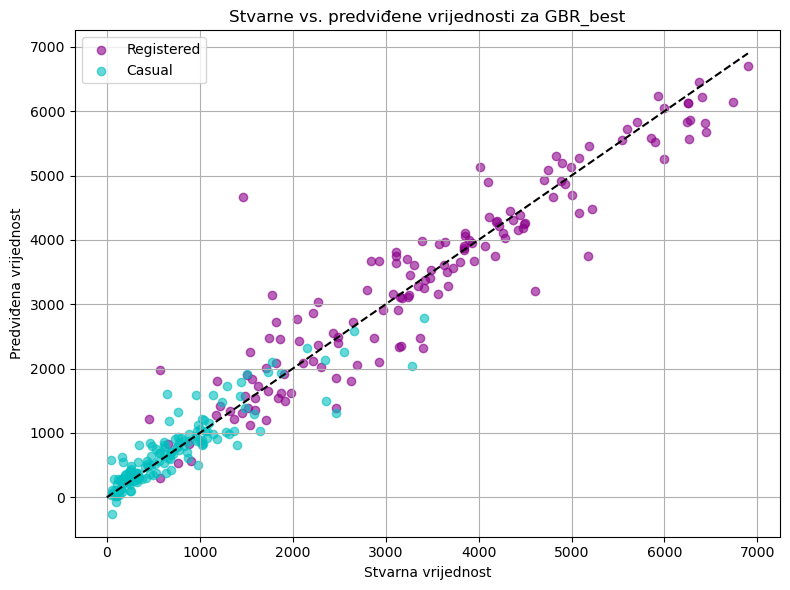

In [72]:
y_pred_gbr = GBR_best.predict(X_test)

# Prava i predviđena vrijednost
y_true_registered = y_test['registered']
y_true_casual = y_test['casual']
y_pred_registered = y_pred_gbr[:, 0]
y_pred_casual = y_pred_gbr[:, 1]

# Graf
plt.figure(figsize=(8, 6))
plt.scatter(y_true_registered, y_pred_registered, color='darkmagenta', alpha=0.6, label='Registered')
plt.scatter(y_true_casual, y_pred_casual, color='c', alpha=0.6, label='Casual')
plt.plot([0, max(y_test.max())], [0, max(y_test.max())], 'k--')
plt.title('Stvarne vs. predviđene vrijednosti za GBR_best')
plt.xlabel('Stvarna vrijednost')
plt.ylabel('Predviđena vrijednost')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Prethodna vizualizacija (scatter plot) prikazuje usporedbu predviđenih i stvarnihi vrijednosti za obje ciljne varijable. Ona potvrđuje da model GradientBoostingRegressor efektivno predviđa vrijednosti za obje cilje varijable, s malim razlikama između stvarne i predviđene vrijednosti.

Prikaz važnosti značajki koje su utjecale za predviđanje obje ciljne varijable:

In [73]:
stvari = ['registered', 'casual']
for i in range(2):
  importances_reg = GBR_best.estimators_[i].feature_importances_
  features = X.columns
  importance_df_reg = pd.DataFrame({'Feature': features, 'Importance': importances_reg}).sort_values(by='Importance', ascending=False)
  print(f"Važnost značajki za {stvari[i]}:")
  print(importance_df_reg)
  print()

Važnost značajki za registered:
      Feature  Importance
0          yr    0.316695
4        temp    0.307101
1        mnth    0.115150
5         hum    0.103712
3  workingday    0.069126
6   windspeed    0.064298
2     weekday    0.023918

Važnost značajki za casual:
      Feature  Importance
4        temp    0.392104
3  workingday    0.301161
5         hum    0.100043
6   windspeed    0.073805
0          yr    0.061257
2     weekday    0.043754
1        mnth    0.027875



Iz dobivenih rezultata vidimo da je varijabla `temp` daleko najvažnija za naš model. Ostale varijable, iako značajne, nisu podjednako važne za obje ciljne vrijednosti, što upućuje na to da casual i registered korisnike treba tretirati odvojeno jer različito reagiraju na atribute.

To je i logično – biciklisti su skloniji vožnji za lijepog vremena; primjerice, nitko ne očekuje voziti bicikl po kiši i jakom vjetru.

Također, vidljivo je da je varijabla `yr` značajnija za `registered` korisnike jer se njihov broj iz godine u godinu znatno povećava. To sugerira da je neki oblik poticaja uspio motivirati ljude na registraciju, dok broj `casual` korisnika stagnira. Moguće je da se radi o specifičnoj skupini ljudi na koju sustav javnih bicikala teško utječe, ili možda potencijal rasta još nije aktiviran. Postoji i mogućnost da ulaganje u tu skupinu jednostavno nije isplativo.

Varijabla `workingday` pokazuje da `casual` korisnici češće koriste bicikl tijekom vikenda. To možemo pretpostaviti kao ponašanje osoba koje se biciklom voze u slobodno vrijeme – kada nisu na poslu, u školi, na fakultetu i slično.



Demonstracija predviđanja:

In [74]:
# Definiranje značajki za predikciju
input_features = ['yr', 'mnth', 'weekday', 'workingday', 'temp', 'hum', 'windspeed']

X_future = pd.DataFrame([
    [0, 8, 0, 0, 0.70, 0.20, 0.20],  # Ljeto, nije praznik, nedjelja, nije radni dan, najbolje vrijeme, odlična temperatura, niska vlaga i umjereni vjetar
    [1, 2, 6, 0, 0.10, 0.10, 0.50],  # Zima, praaznik, subota, nije radni dan, najgore vrijeme, lošu vremenski uvjeti
    [1, 4, 4, 1, 0.45, 0.40, 0.30]   # Proljeće, 0, cetvrtak, radni dan, oke vrijeme
], columns=input_features)

# Predikcija
y_pred_future = GBR_best.predict(X_future)

# Ispis rezultata
for i, (reg, cas) in enumerate(y_pred_future):
    print(f"Scenarij {i+1}:")
    print(f"  Predicted Registered: {reg:.0f}")
    print(f"  Predicted Casual:    {cas:.0f}")
    print(f"  Total Users:         {reg + cas:.0f}\n")


Scenarij 1:
  Predicted Registered: 2891
  Predicted Casual:    2061
  Total Users:         4952

Scenarij 2:
  Predicted Registered: 1815
  Predicted Casual:    332
  Total Users:         2147

Scenarij 3:
  Predicted Registered: 5331
  Predicted Casual:    945
  Total Users:         6277



In [75]:
# Nasumični uzorci iz testnog skupa
np.random.seed(24)
sample_idxs = np.random.choice(X_test.index, 2, replace=False)
X_sample = X_test.loc[sample_idxs]
y_true_sample = y_test.loc[sample_idxs]

# Predikcija
y_pred_sample = GBR_best.predict(X_sample)

# Usporedba stvarnih i predviđenih vrijednosti
for i in range(2):
    print(f"Primjer {i+1}:")
    print(f"  Registered - stvarno: {y_true_sample.iloc[i, 0]}, predviđeno: {y_pred_sample[i, 0]:.0f}")
    print(f"  Casual     - stvarno: {y_true_sample.iloc[i, 1]}, predviđeno: {y_pred_sample[i, 1]:.0f}")
    print(f"  Ukupno     - stvarno: {y_true_sample.iloc[i, 0] + y_true_sample.iloc[i, 1]}, "
          f"predviđeno: {y_pred_sample[i, 0] + y_pred_sample[i, 1]:.0f}\n")


Primjer 1:
  Registered - stvarno: 4934, predviđeno: 4862
  Casual     - stvarno: 333, predviđeno: 372
  Ukupno     - stvarno: 5267, predviđeno: 5234

Primjer 2:
  Registered - stvarno: 5187, predviđeno: 5454
  Casual     - stvarno: 1005, predviđeno: 1065
  Ukupno     - stvarno: 6192, predviđeno: 6519



## 6. Vrednovanje

### 6.1. Evaluacija rezultata

Dobiveni rezultati pokazuju da modeli znatno bolje predviđaju casual korisnike nego registered korisnike, što ukazuje na nedostatak dovoljno podataka i konteksta za preciznu predikciju registered korisnika.

Za vrlo mali skup podataka, model Gradient Boosting Regressor (GBR) bez varijable `yr` postiže točnost od 76% za casual i 63% za registered korisnike. Kada se uključi varijabla `yr`, točnost se povećava na 81% za casual i čak 88% za registered korisnike.

Ovo jasno pokazuje koliko je `yr` važan atribut. Međutim, model `yr` tretira kao binarnu varijablu — vrijednosti su ili 0 ili 1, dok bilo koja vrijednost veća ili jednaka 2 daje isti rezultat kao 1.

Zaključujemo da bi za modeliranje vremenskog trenda na više godina trebalo drugačije kodirati `yr`, npr. dodavanjem +2011 ili pomakom za +1. Međutim, stabla odlučivanja i slični modeli teško extrapoliraju izvan poznatih vrijednosti.

S obzirom na ograničenost podataka i karakteristike modela, najpraktičniji pristup za sada je izostaviti `yr` i umjesto toga pratiti kontinuirani rast korisnika kroz vrijeme, bez ručnog grupiranja po godinama.

Takav pristup može biti korisniji, jer biciklizam je sezonska aktivnost i dvije godine predstavljaju tek dva seta sezona, a ne potpuno nezavisne vremenske jedinice.


Još trebao komentirati na probleme sezonalnosti našeg zadatka.

Očigledan je trend porasta broja korisnika iz godine u godinu, iako je djelomično prikriven varijablama poput godišnjih doba. Međutim, ta je varijabla u tolikoj mjeri korelirana s mjesecima da smo je odlučili izostaviti, jer mjeseci pružaju detaljniju vremensku informaciju. Budući da se godišnje doba mijenja samo dvaput godišnje, ono obuhvaća tek oko 8 % baze podataka po mjesecima.

Važno je naglasiti da je naš skup podataka vremenski i sezonski osjetljiv, a mi pritom raspolažemo ograničenim brojem takvih zapisa. Upravo zbog toga pristup rješavanju takvih problema predstavlja prostor za napredak. Naglašavamo da je glavni izazov bio nedostatak iskustva – o ovakvim pitanjima mogli bismo raspravljati satima kako bismo pronašli najoptimalniji način preoblikovanja podataka za što preciznije modele.


Druga istražinja poput:
 - "[Bike Sharing Demand Prediction](https://medium.com/@muhammadaris10/bike-sharing-demand-prediction-fc692d90b5b3)" su dobili bolje rezultate na prvi pogled ali ne vidimo nikakvo čišćenje podataka i opet nisu nikako predviđali budućnost već sve moguće scenarije unutar "tih godina". Isto tako oni su imali pristup "Hour" sat u danu koje bi očito poboljšalo model.

 - [Decision Trees - Predicting Bike Rentals](https://www.kaggle.com/code/hamzajabbarkhan/decision-trees-predicting-bike-rentals) <je budala>
je savršen primjer osobe koja treba polagati kolegije "Primjena umjetne inteligencije u poslovanju" i "Otkrivanje znanja u podacima" jer ima previše grešaka.

S time, kako nismo uspjeli naći adekvatno dobre radove na internetu koji su se bavili istim podatcima kao i mi, možemo samo dati komentare na naš rad.

### 6.2. Ocjenjivanje procesa

Sam proces izrade bio je izvrsno iskustvo za učenje, osobito zato što se radilo o jednostavnoj, ali analitički zahtjevnoj bazi podataka. Zadani podaci zahtijevali su dosta promišljanja i primjenu dosad naučenih metoda kako bismo izgradili kvalitetne modele.

Uložili smo velik trud u kritičko promišljanje kroz cijeli postupak, a tek nakon što smo prvi put pokrenuli sve modele, shvatili smo koliko toga zapravo nismo znali. Taj trenutak dao nam je bolji uvid u način na koji modeli funkcioniraju, njihovu primjenu i ograničenja. Iako nismo sigurni je li dio naših zaključaka možda rezultat učinka „lažno pozitivnog” (False Positive), pokušali smo doista razumjeti mehaniku modela, a ne samo promatrati rezultate.

Što se tiče praktične primjene, jasno je da izvorni skup podataka vjerojatno sadrži puno više informacija koje nadilaze okvire ovog kolegija. Ograničeni podaci ograničavaju i našu interpretaciju. Na primjer, ne možemo donijeti zaključak poput “Sniženje pretplate povećat će broj korisnika” jer nemamo podatke o cijenama ili postojanju pretplatničkog modela.

Zbog toga bismo iskustvo rada ponajprije opisali kao priliku za učenje o čišćenju i obradi podataka, treniranju i evaluaciji modela.

4.5/5 za bazu podataka. 5/5 za iskustvno procesa.

Naši dodatni zaključci vezani uz konkretnu primjenu modela bit će istaknuti u točki 7: Korištenje.


###6.3. Određivanje sljedećih koraka

Kao što je naglašeno, trebalo bi ili imati više godina za analizirati ako je moguće. Inače više varijabli poput "hour" ili adaptacija modela da je vremenski osjetljiv jer postoji očiti trend povećanja broja korisnika kroz vrijeme.


###7. Korištenje

Praktične primjene dobivenih rezultata ograničene su zbog male količine korisnih podataka. Jedna od preporuka je analizirati periode s najvećim prosječnim brojem vozača te u tim vremenskim intervalima organizirati događaje koji bi privukli trenutne korisnike, ali i zainteresirane treće strane. Time bi se povećala prepoznatljivost tvrtke i unaprijedile marketinške aktivnosti temeljem veće koncentracije ljudi.

`registered` korisnike ne dotiču gotovo nikakve varijable osim možda vremenskih uvjeta, što je izvan naše kontrole. Neke pogodnosti za one koji žele ili moraju voziti bicikl i po lošem vremenu mogle bi biti korisne, ali kako nemamo uvid u to što se trenutačno nudi ni koliki broj takvih korisnika postoji, to ostaje nagađanje.

Ono što je jasno jest da su `registered` korisnici skupina koja koristi bicikle neovisno o većini okolnosti – kao svakodnevno prijevozno sredstvo. Uz prethodno spomenuto organiziranje događaja, bilo bi logično usmjeriti resurse u promociju citybike bicikala kao svakodnevnog sredstva prijevoza – za posao ili opće kretanje po gradu – posebno u skupinama ljudi i gradskim četvrtima koje još nisu upoznate s tom mogućnošću (ako takve postoje).

Za `casual` korisnike, pretpostavlja se da su skloniji korištenju bicikla vikendom zbog utjecaja varijable `workingday`. Bilo bi korisno iskoristiti taj uvid – primjerice, organizirati vikend događanja poput izazova "prijeđi 10 kilometara u danu". Ovakve inicijative mogu potaknuti dosljednije korištenje među povremenim korisnicima.

Ove pretpostavke nisu strogo vezane uz podatke jer je podataka premalo, kako smo već naveli. No, ako su pretpostavke točne, tada su i preporuke valjane za primjenu – stoga sve navedeno treba uzeti s određenom dozom rezerve.

In [76]:
final.to_csv("data/Perenčević_Kos_Izazov365.csv", index=False)